# Air Quality Foreasting ($CO_2$ emissions) 
## **Business Objective:**
## To forecast $CO_2$ levels for an organization so that the organization can follow government norms with respects to $CO_2$ emission levels.
### Prepare a ppt for each step taken like EDA, Feature Engineering, Model Building,  Model Evaluation and Predicition table, and Deployment. Explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

## Model Building Phase On Raw data

### Importing the libraries required

In [1]:
# Importing 
# Libraries
import dtale

import warnings
import itertools
%matplotlib inline
import numpy as np
import pandas as pd

from math import sqrt
import seaborn as sns

import missingno as mn
import plotly.io as pio
sns.set_style('darkgrid')

from pandas import Grouper
import scipy.stats as stat
import plotly.express as px
from pandas import DataFrame

import statsmodels.api as smf
import pandas_profiling as pp
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
import plotly.figure_factory as ff

from pandas.plotting import lag_plot
import statsmodels.formula.api as sm
from plotly.offline import plot as off
from plotly.subplots import make_subplots

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.feature_selection import SelectKBest
from pandas_visual_analysis import VisualAnalysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES

from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale, RobustScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

In [2]:
data=pd.read_excel('C:/Users\Moin Dalvi\Documents\Data Science Material\Projects\Air Quality Forecasting/CO2 dataset.xlsx'\
                   ,index_col='Year',parse_dates=True)

#data.set_index('Year', inplace=True)
data.index = pd.DatetimeIndex(data.index.values,freq=data.index.inferred_freq)
data.head()

,CO2
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [3]:
upsampled_month = data.copy()
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                CO2
1800-01-31  0.00568
1800-02-28      NaN
1800-03-31      NaN
1800-04-30      NaN
1800-05-31      NaN
1800-06-30      NaN
1800-07-31      NaN
1800-08-31      NaN
1800-09-30      NaN
1800-10-31      NaN
1800-11-30      NaN
1800-12-31      NaN
1801-01-31  0.00561


In [4]:
interpolated_month = upsampled_month.interpolate(method='linear') 
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(16,6))
plt.title("Interpolation uisng Linear Method", fontsize =  14)
plt.show()

                 CO2
1800-01-31  0.005680
1800-02-28  0.005674
1800-03-31  0.005668
1800-04-30  0.005662
1800-05-31  0.005657
1800-06-30  0.005651
1800-07-31  0.005645
1800-08-31  0.005639
1800-09-30  0.005633
1800-10-31  0.005628
1800-11-30  0.005622
1800-12-31  0.005616
1801-01-31  0.005610
1801-02-28  0.005605
1801-03-31  0.005600


In [15]:
interpolated_month.duplicated(keep=False).sum()

704

In [5]:
df = interpolated_month[1080:]

In [6]:
df

,CO2
1890-01-31,2.530000
1890-02-28,2.553333
1890-03-31,2.576667
1890-04-30,2.600000
1890-05-31,2.623333
...,...
2013-09-30,14.966667
2013-10-31,15.000000
2013-11-30,15.033333
2013-12-31,15.066667


### Splitting Train and Test Data on Original data 

#### Leaving Test Data with 5 Years of Time Series
+ **Training Data** = Fit the model only to training period. 
+ **Testing Data** = Assess the model performance on Testing. 
+ **Deploy model by training on whole dataset. No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.**

In [5]:
size = -49
train_data = df[0:size]
test_data = df[size:]

In [9]:
train_data.head()

,CO2
1890-01-31,2.530000
1890-02-28,2.553333
1890-03-31,2.576667
1890-04-30,2.600000
1890-05-31,2.623333


In [10]:
train_data.shape

(1440, 1)

In [11]:
test_data.tail()

,CO2
2013-09-30,14.966667
2013-10-31,15.000000
2013-11-30,15.033333
2013-12-31,15.066667
2014-01-31,15.100000


In [12]:
test_data.shape

(49, 1)

In [56]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1890-01-31 00:00:00 2009-12-31 00:00:00 
 Test: 2010-01-31 00:00:00 2014-01-31 00:00:00


### We are going to forecast for the last 5 years. that is from 2010 to 2014.

##### Last 49 records contain data from 2010 to 2014 data.

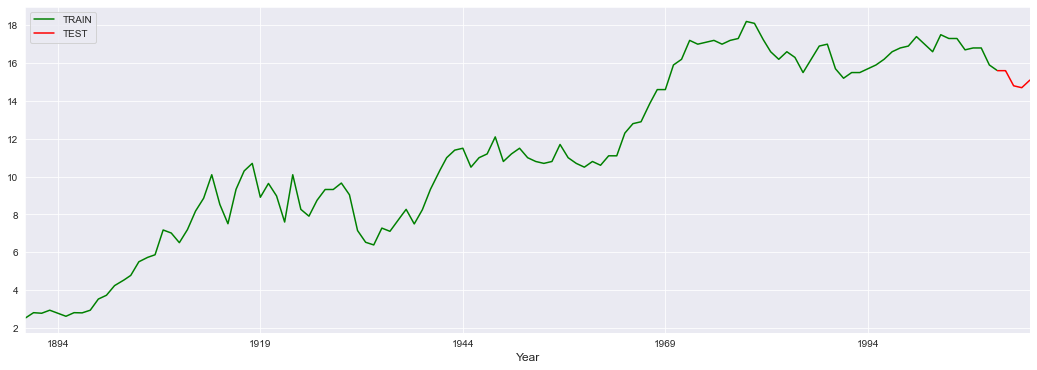

In [107]:
train_data.CO2.plot(legend=True,label='TRAIN',color='green')
test_data.CO2.plot(legend=True,label='TEST', figsize=(18,6),color='red')
plt.xlabel('Year', fontsize= 12)
plt.legend()
plt.show()

In [6]:
%matplotlib inline

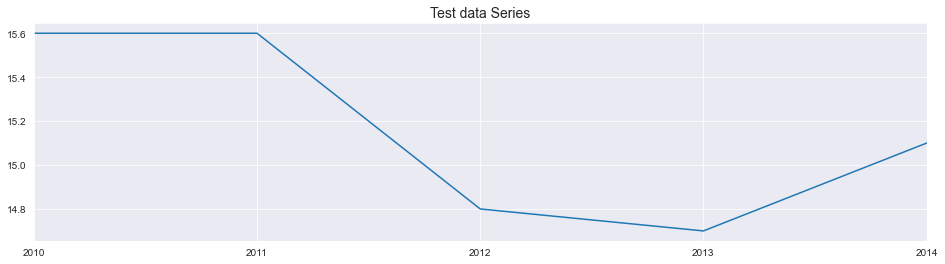

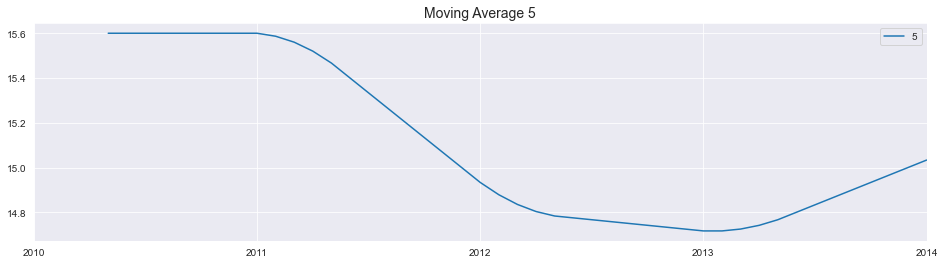

In [108]:
plt.figure(figsize=(16,4))
test_data.CO2.plot(label="org")
plt.title("Test data Series", fontsize=14)
plt.figure(figsize=(16,4))
test_data["CO2"].rolling(5).mean().plot(label=str(5))
plt.title("Moving Average "+str(5), fontsize=14)
plt.legend(loc='best')
plt.show()

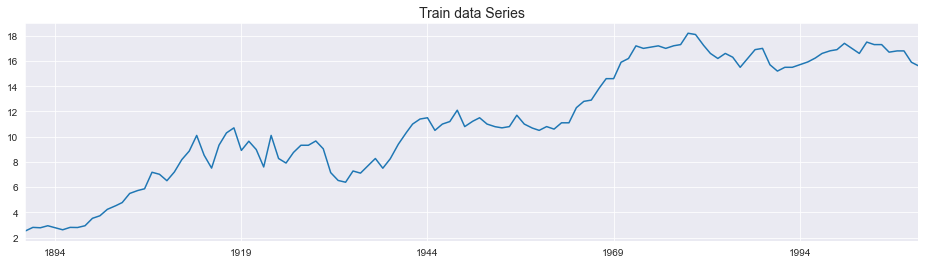

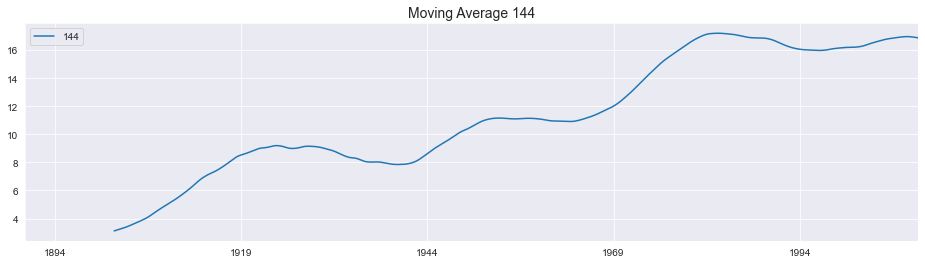

In [109]:
plt.figure(figsize=(16,4))
train_data.CO2.plot(label="org")
plt.title("Train data Series", fontsize=14)
plt.figure(figsize=(16,4))
train_data["CO2"].rolling(144).mean().plot(label=str(144))
plt.title("Moving Average "+str(144), fontsize=14)
plt.legend(loc='best')
plt.show()

### Evaluation Metric MAPE

In [21]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Model Building

___
## Exponential Methods
### Simple Exponential Method

#### Using Forecast Attribute

In [40]:
ses_model = SimpleExpSmoothing(train_data['CO2']).fit(optimized=True)
test_pred_ses = ses_model.forecast(49)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.CO2))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 3.413068421601222 
 Train Root Mean Squared Error = 0.06036645536912902 
 Test Root Mean Squared Error = 0.6165965673832795


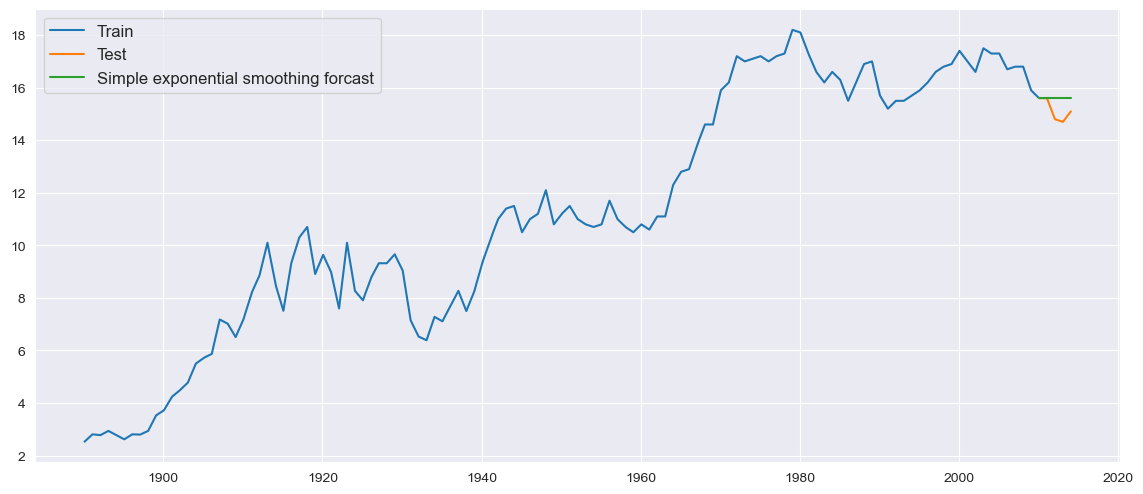

In [112]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. **This method doesn't captures seasonality.**

---
### Holt method (Double Exponential) 

##### Captures both Level and Trend .

In [41]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(49)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.CO2))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 1.2306827142236503 
 Train Root Mean Squared Error = 0.024897203957784046 
 Test Root Mean Squared Error = 0.24813933435008517


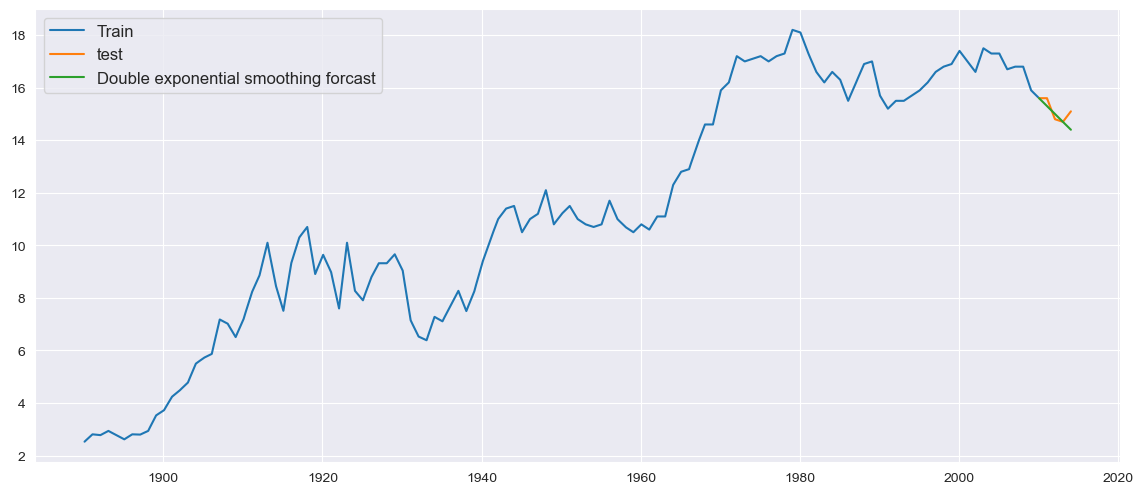

In [114]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that we are able to capture the trend of the data.
2. We were not able to capture the seasonality.

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

##### Captures Level, Trend and Seasonality.

In [42]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(49)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.CO2))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.CO2)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 1.2372978397065775 
 Train Root Mean Squared Error = 0.02489695362647203 
 Test Root Mean Squared Error = 0.2506152649840835


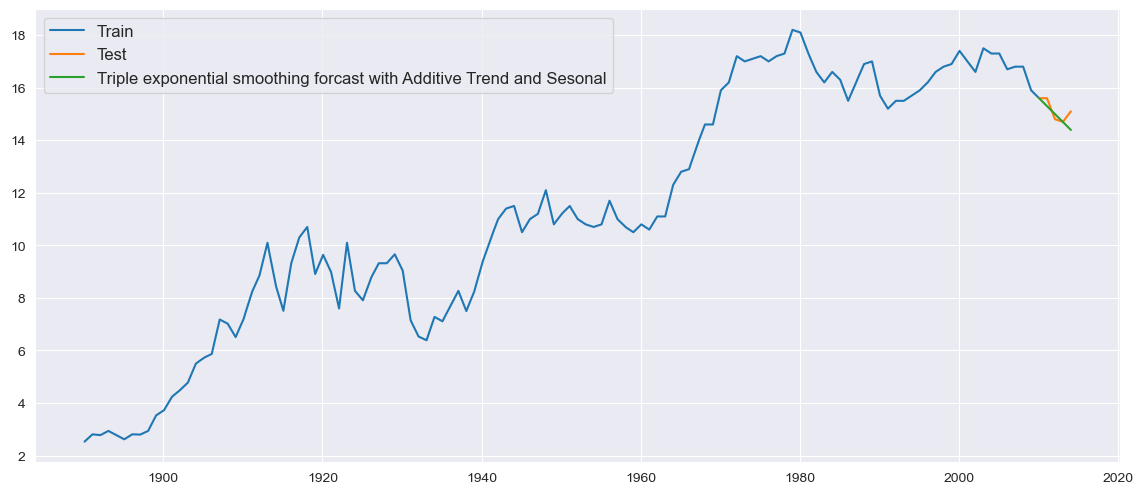

In [116]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. It captures the trend, but which we can see that the forecasted values are higher level than the test level.
2. It doesn't captures the seasonality.

### Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [43]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(49)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.CO2))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.CO2)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 1.316404920595192 
 Train Root Mean Squared Error = 0.024875068309131988 
 Test Root Mean Squared Error = 0.2754981854604523


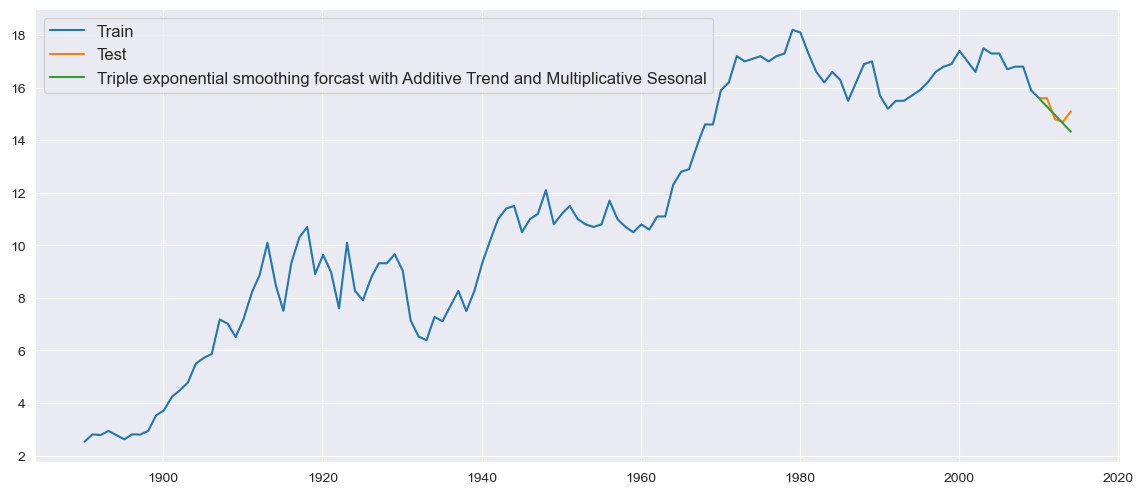

In [118]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that the errors have not reduced, we are not able to capture the seasonality.

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [44]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(49)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.CO2))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.CO2)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 1.216806145853403 
 Train Root Mean Squared Error = 0.024918952784596562 
 Test Root Mean Squared Error = 0.24254162483101882


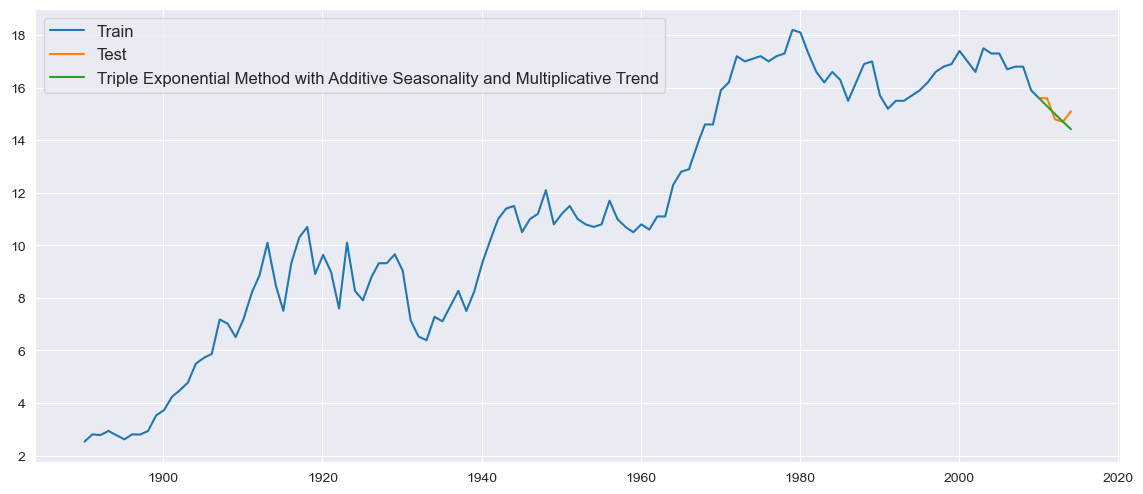

In [120]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best', fontsize=12)
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [45]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(49)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.CO2))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.CO2)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 1.2880755685275869 
 Train Root Mean Squared Error = 0.024894665296472093 
 Test Root Mean Squared Error = 0.2670701324937177


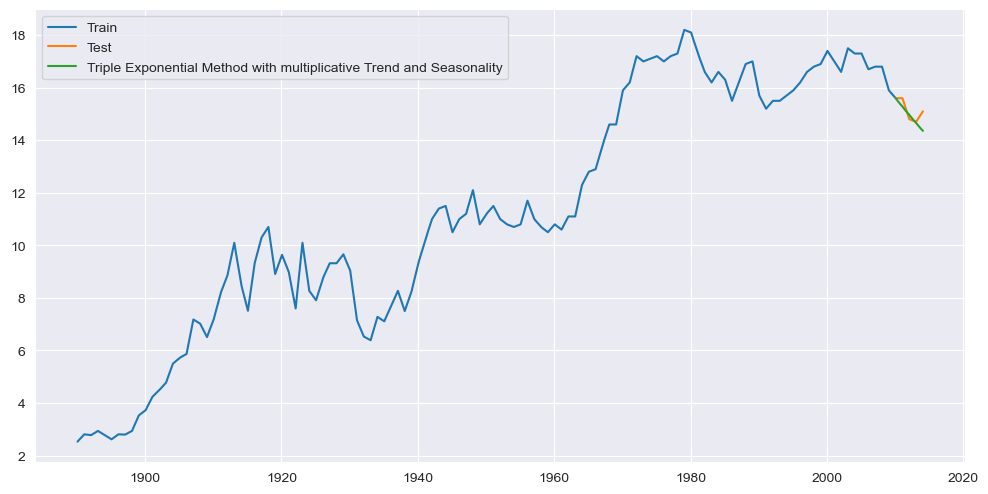

In [122]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

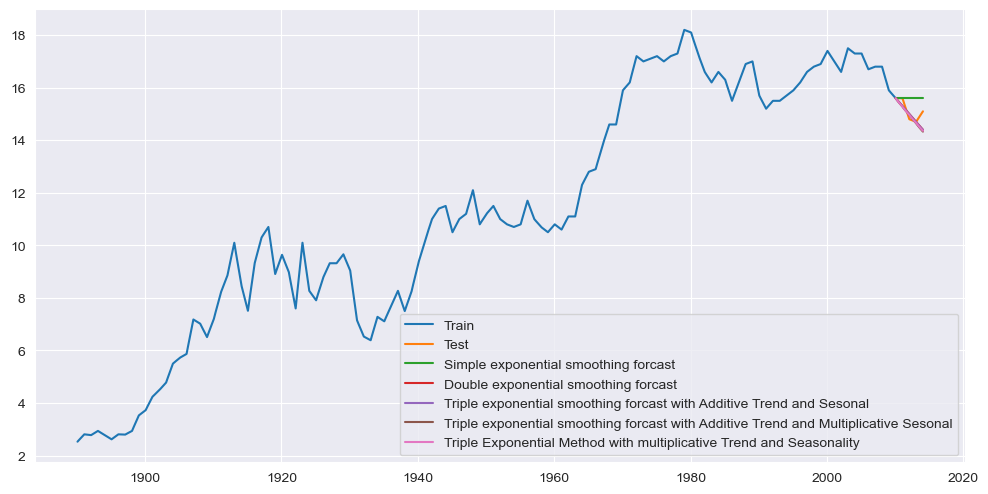

In [123]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

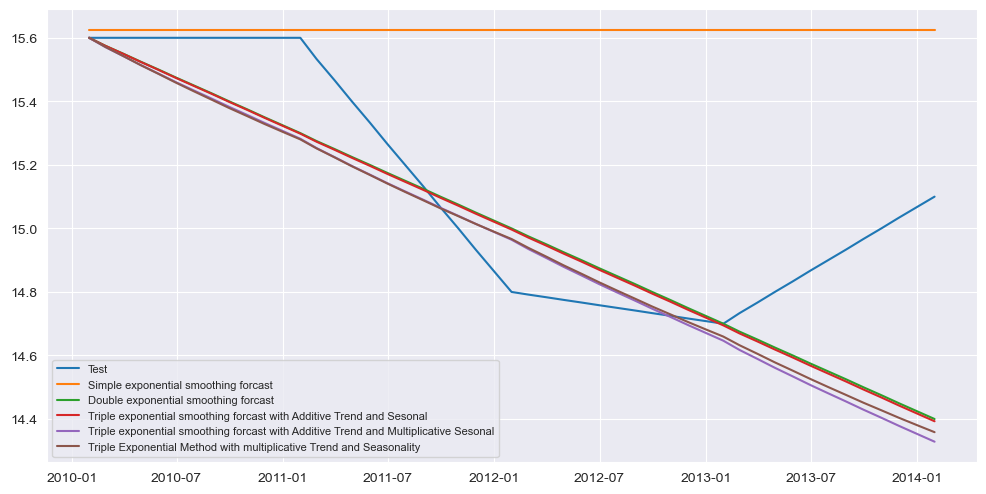

In [124]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best', fontsize=8)
plt.show()

In [46]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_ad_mul,0.024919,1.216806,0.242542
1,Double_Exp,0.024897,1.230683,0.248139
2,Triple_Exp_ad,0.024897,1.237298,0.250615
3,Triple_Exp_mul,0.024895,1.288076,0.267070
4,Triple_Exp_mul_ad,0.024875,1.316405,0.275498
5,Simple_Exp,0.060366,3.413068,0.616597


### Visualizing Models Performance

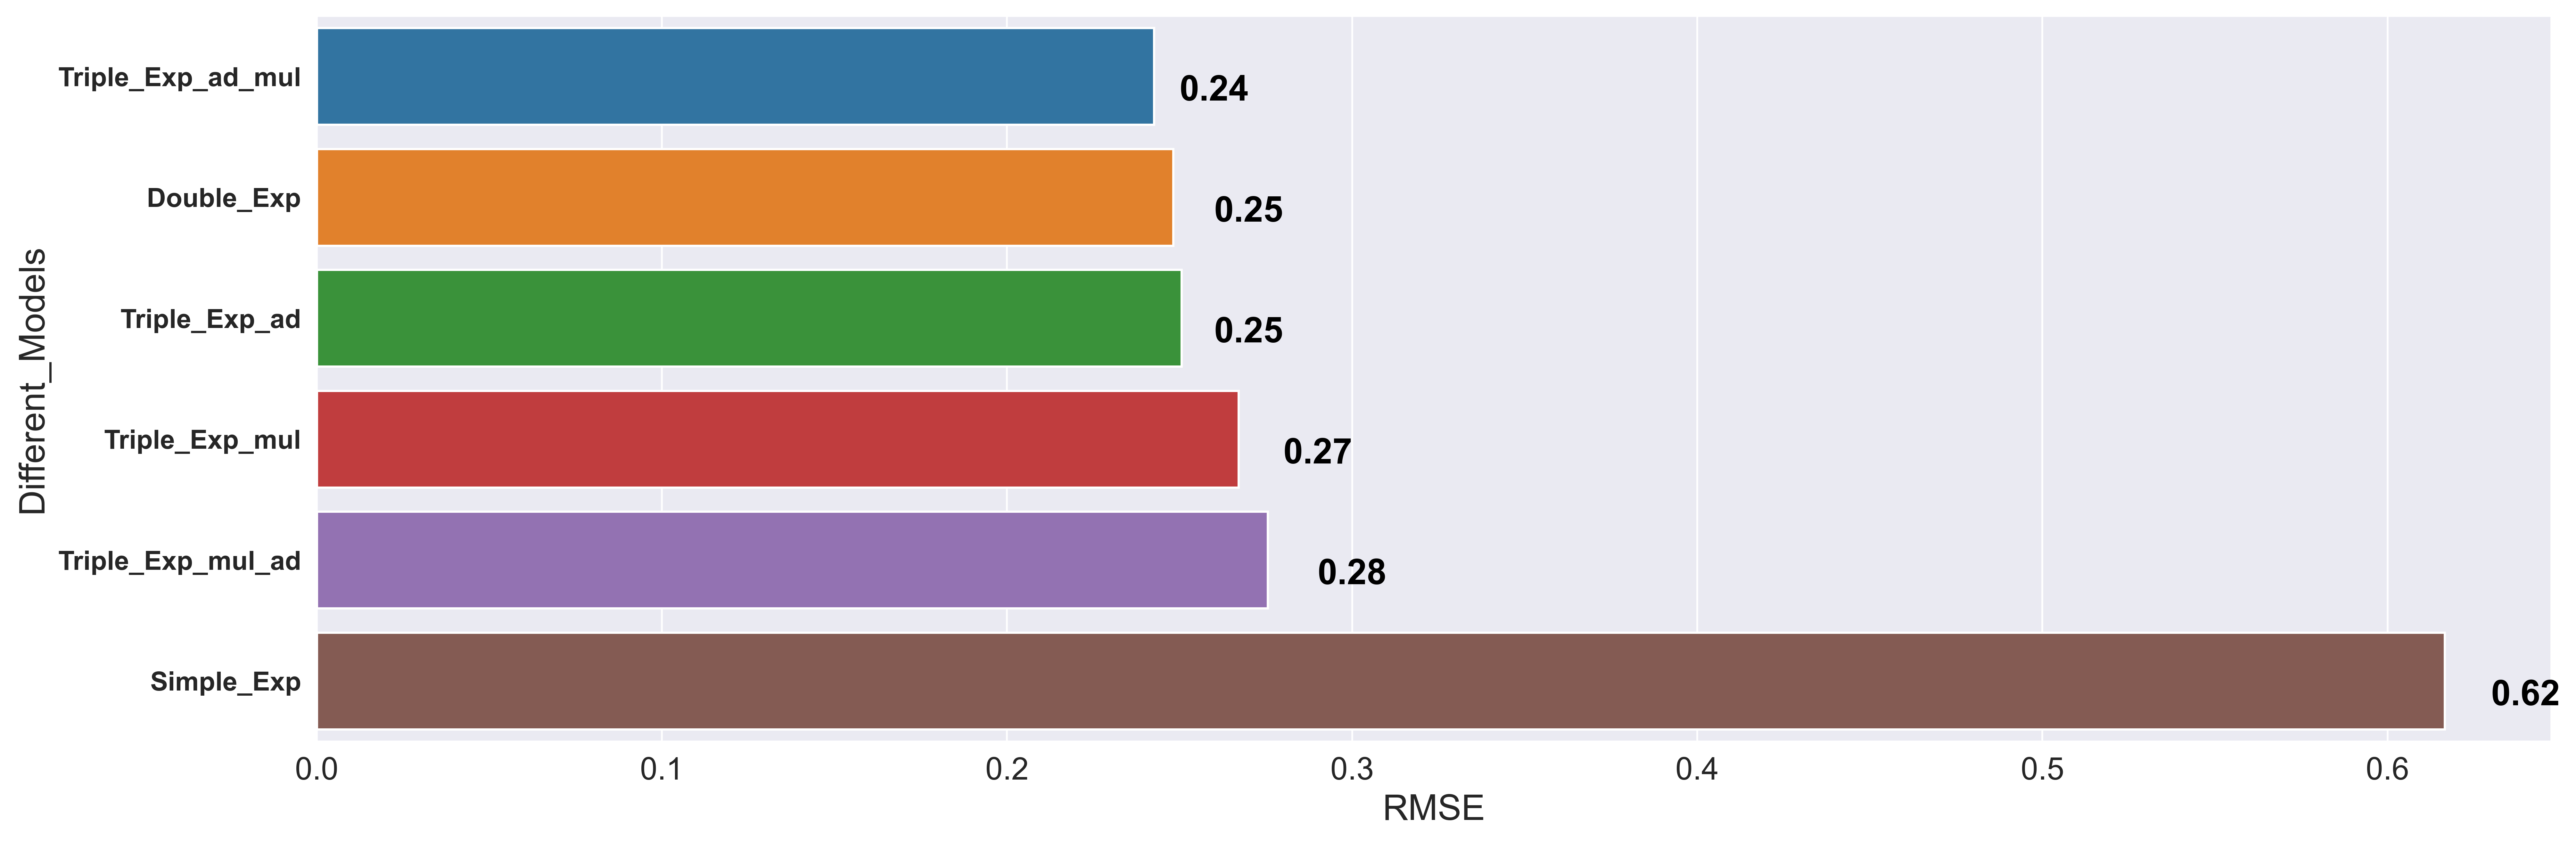

In [126]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,2)):
    axe.text(v + 0.01, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

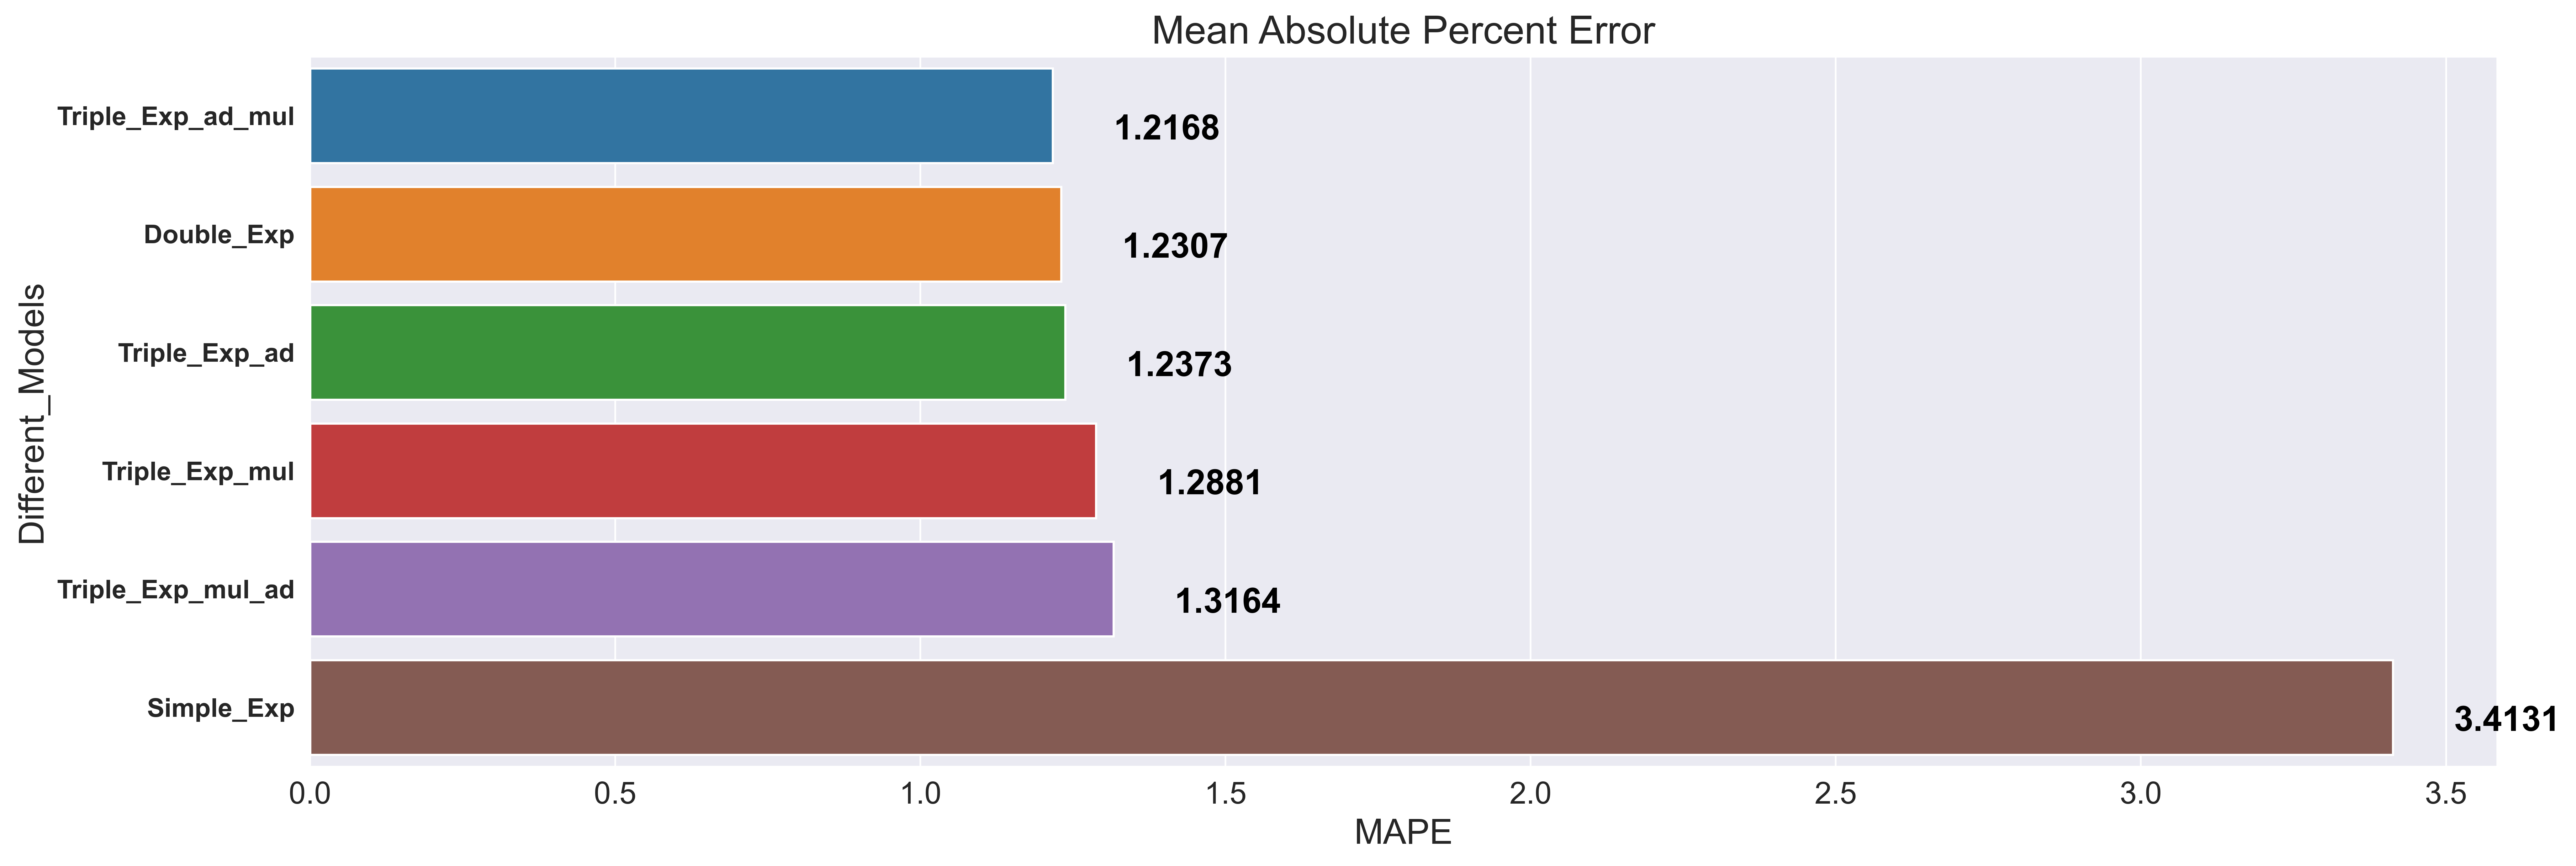

In [127]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_MAPE(%)', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('MAPE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.title("Mean Absolute Percent Error", fontsize = 18)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation['Test_MAPE(%)'].values,4)):
    axe.text(v + 0.1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

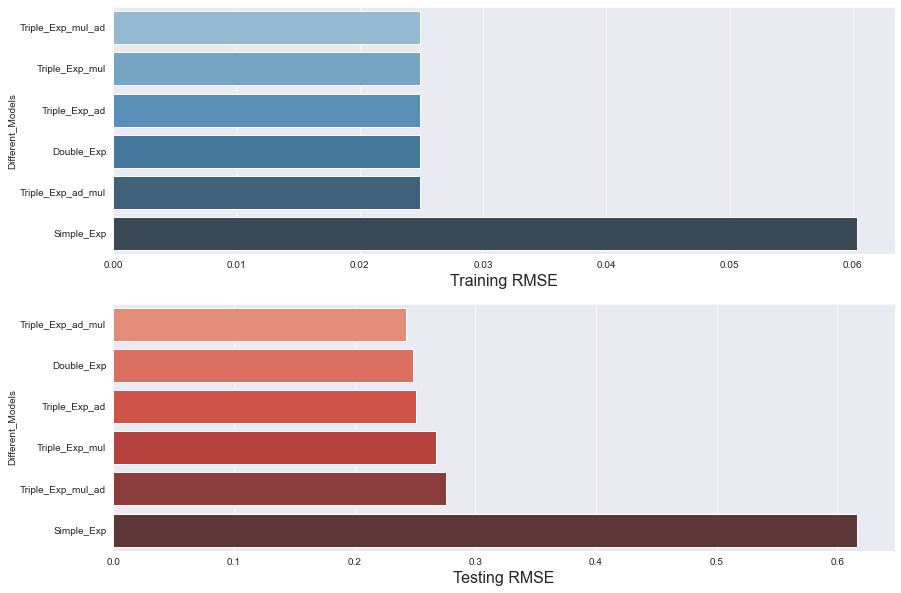

In [128]:
f, axes = plt.subplots(2,1, figsize=(14,10))
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=True)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=True)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

### Assumptions of ARIMA model
1. **Data should be stationary** – by stationary it means that the properties of the series doesn’t depend on the time when it is captured. A white noise series and series with cyclic behavior can also be considered as stationary series.
2. **Data should be univariate** – ARIMA works on a single variable. Auto-regression is all about regression with the past values.

#### Stationary vs Non-stationary Time Series

## ARIMA Hyperparameter Tuning

***order(p,d,q)***

p = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series.

d = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary.


q = This variable denotes the lag of the error component, where error component is a part of the time series not explained by trend or seasonality.

In [48]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [13]:
import itertools

In [14]:
p = range(0,8)
q = range(0,8)
d = range(0,5)

In [15]:
pqd_combination = list(itertools.product(p,d,q))

In [16]:
len(pqd_combination)

320

In [17]:
rmse = []
order = []

In [18]:
for pdq in pqd_combination:
    try:
        model = ARIMA(train_data, order=pdq).fit()
        pred = model.forecast(49)
        error = np.sqrt(mean_squared_error(test_data,pred))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

In [107]:
value_pqd = pd.DataFrame(index=order,data=rmse,columns=['rmse'])
value_pqd.sort_values('rmse')

,rmse
"(5, 1, 6)",0.195375
"(5, 0, 4)",0.203329
"(6, 0, 5)",0.205734
"(7, 0, 6)",0.206325
"(2, 2, 2)",0.207753
...,...
"(0, 0, 4)",8.303536
"(0, 0, 3)",8.352531
"(0, 0, 2)",8.406980
"(0, 0, 1)",8.475382


In [19]:
results = pd.DataFrame(index=order,data=rmse,columns=['RMSE'])
results.sort_values('RMSE')

,RMSE
"(2, 4, 5)",0.176967
"(6, 4, 7)",0.185249
"(7, 4, 6)",0.187984
"(7, 4, 7)",0.191908
"(3, 4, 6)",0.193129
...,...
"(0, 0, 4)",3.731917
"(0, 0, 3)",3.762556
"(0, 0, 2)",3.782807
"(0, 0, 1)",3.816098


In [35]:
data.values

array([[5.68e-03],
       [5.61e-03],
       [5.55e-03],
       [5.48e-03],
       [5.42e-03],
       [5.36e-03],
       [5.29e-03],
       [5.23e-03],
       [5.17e-03],
       [5.11e-03],
       [5.04e-03],
       [4.97e-03],
       [4.90e-03],
       [4.83e-03],
       [4.75e-03],
       [4.66e-03],
       [4.57e-03],
       [4.47e-03],
       [4.38e-03],
       [4.27e-03],
       [4.17e-03],
       [4.06e-03],
       [3.95e-03],
       [3.84e-03],
       [3.73e-03],
       [3.62e-03],
       [3.50e-03],
       [3.39e-03],
       [3.27e-03],
       [3.16e-03],
       [3.05e-03],
       [2.94e-03],
       [2.83e-03],
       [2.73e-03],
       [2.63e-03],
       [2.53e-03],
       [2.44e-03],
       [2.35e-03],
       [2.27e-03],
       [2.18e-03],
       [2.10e-03],
       [2.02e-03],
       [1.95e-03],
       [1.88e-03],
       [1.81e-03],
       [1.75e-03],
       [1.18e-02],
       [1.47e-02],
       [1.74e-02],
       [1.98e-02],
       [2.36e-02],
       [2.71e-02],
       [3.18

In [38]:
import pmdarima as pm

hyper = pm.auto_arima(data.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=8, max_q=8,max_d=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(hyper.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=355.595, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=353.513, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=355.231, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=355.157, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=355.035, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.331 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  215
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -174.756
Date:                Sun, 14 Aug 2022   AIC                            353.513
Time:                        01:03:02   BIC                            360.245
Sample:                             0   HQIC                           356.233
                                - 215                                         
Co

In [20]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [21]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

### ARIMA Hyperparameter Tuning using Original Time series.

In [ ]:
# evaluate parameters
p_values = range(0, 8)
d_values = range(0, 8)
q_values = range(0, 5)
evaluate_models(train_data.values, test_data.values, p_values, d_values, q_values)

### ^Observation: After using Resampled dataset we got the best optimal values

In [53]:
arima_model = ARIMA(train_data, order=(5, 1, 6))
arima_model_fit = arima_model.fit()
y_hat_ar = df.copy()
y_hat_ar['arima_forecast'] = arima_model_fit.predict(df.index.min(), df.index.max())

In [19]:
y_hat_ar

,CO2,arima_forecast
1890-01-31,2.530000,2.530916
1890-02-28,2.553333,2.543604
1890-03-31,2.576667,2.578305
1890-04-30,2.600000,2.600243
1890-05-31,2.623333,2.622527
...,...,...
2008-09-30,16.200000,16.217670
2008-10-31,16.125000,16.128027
2008-11-30,16.050000,16.048957
2008-12-31,15.975000,15.974787


In [17]:
%matplotlib inline

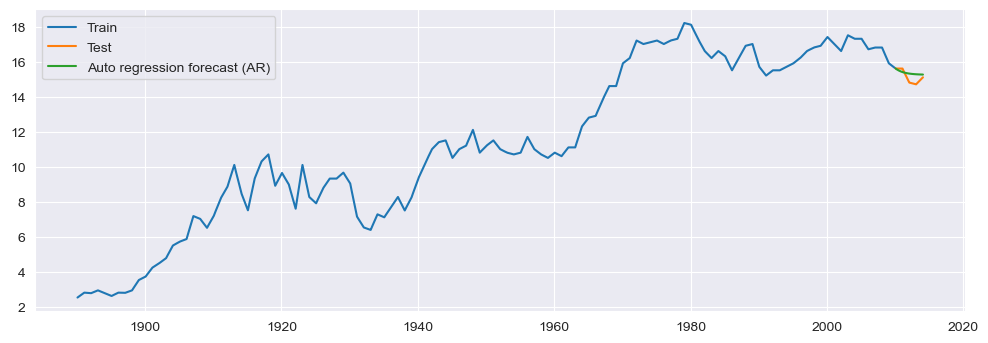

In [17]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [62]:
arima_model = ARIMA(train_data, order=(6, 4, 7))
arima_model_fit = arima_model.fit()
y_hat_ar = df.copy()
pred = arima_model_fit.forecast(49)
y_hat_ar['arima_forecast'] = arima_model_fit.predict(df.index.min(), df.index.max())

In [31]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                 1440
Model:                 ARIMA(5, 4, 7)   Log Likelihood                3286.470
Date:                Sun, 14 Aug 2022   AIC                          -6546.940
Time:                        00:57:34   BIC                          -6478.435
Sample:                    01-31-1890   HQIC                         -6521.364
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.1742      0.029   -111.244      0.000      -3.230      -3.118
ar.L2         -5.0623      0.068    -74.360      0.000      -5.196      -4.929
ar.L3         -4.9733      0.091    -54.357      0.000      -5.153      -4.794
ar.L4         -3.0055      0.070    -43.053      0.000      -3.142      -2.869
ar.L5         -0.8901      0.032    -27.771      0.000      -0.953      -0.827
ma.L1          1.2709      0.031     41.416      0.000       1.211       1.331
ma.L2         -0.2772      0.049     -5.660      0.000      -0.373      -0.181
ma.L3         -2.0185      0.046    -44.044      0.000      -2.108      -1.929
ma.L4         -1.9469      0.050    -38.847      0.000      -2.045      -1.849
ma.L5         -0.1781      0.048     -3.713      0.000      -0.272      -0.084
ma.L6          1.2321      0.046     26.618      0.000       1.141       1.323
ma.L7          0.9201      0.031     29.826      0.000       0.860       0.981
sigma2         0.0006   1.05e-05     55.960      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):            248207.26
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

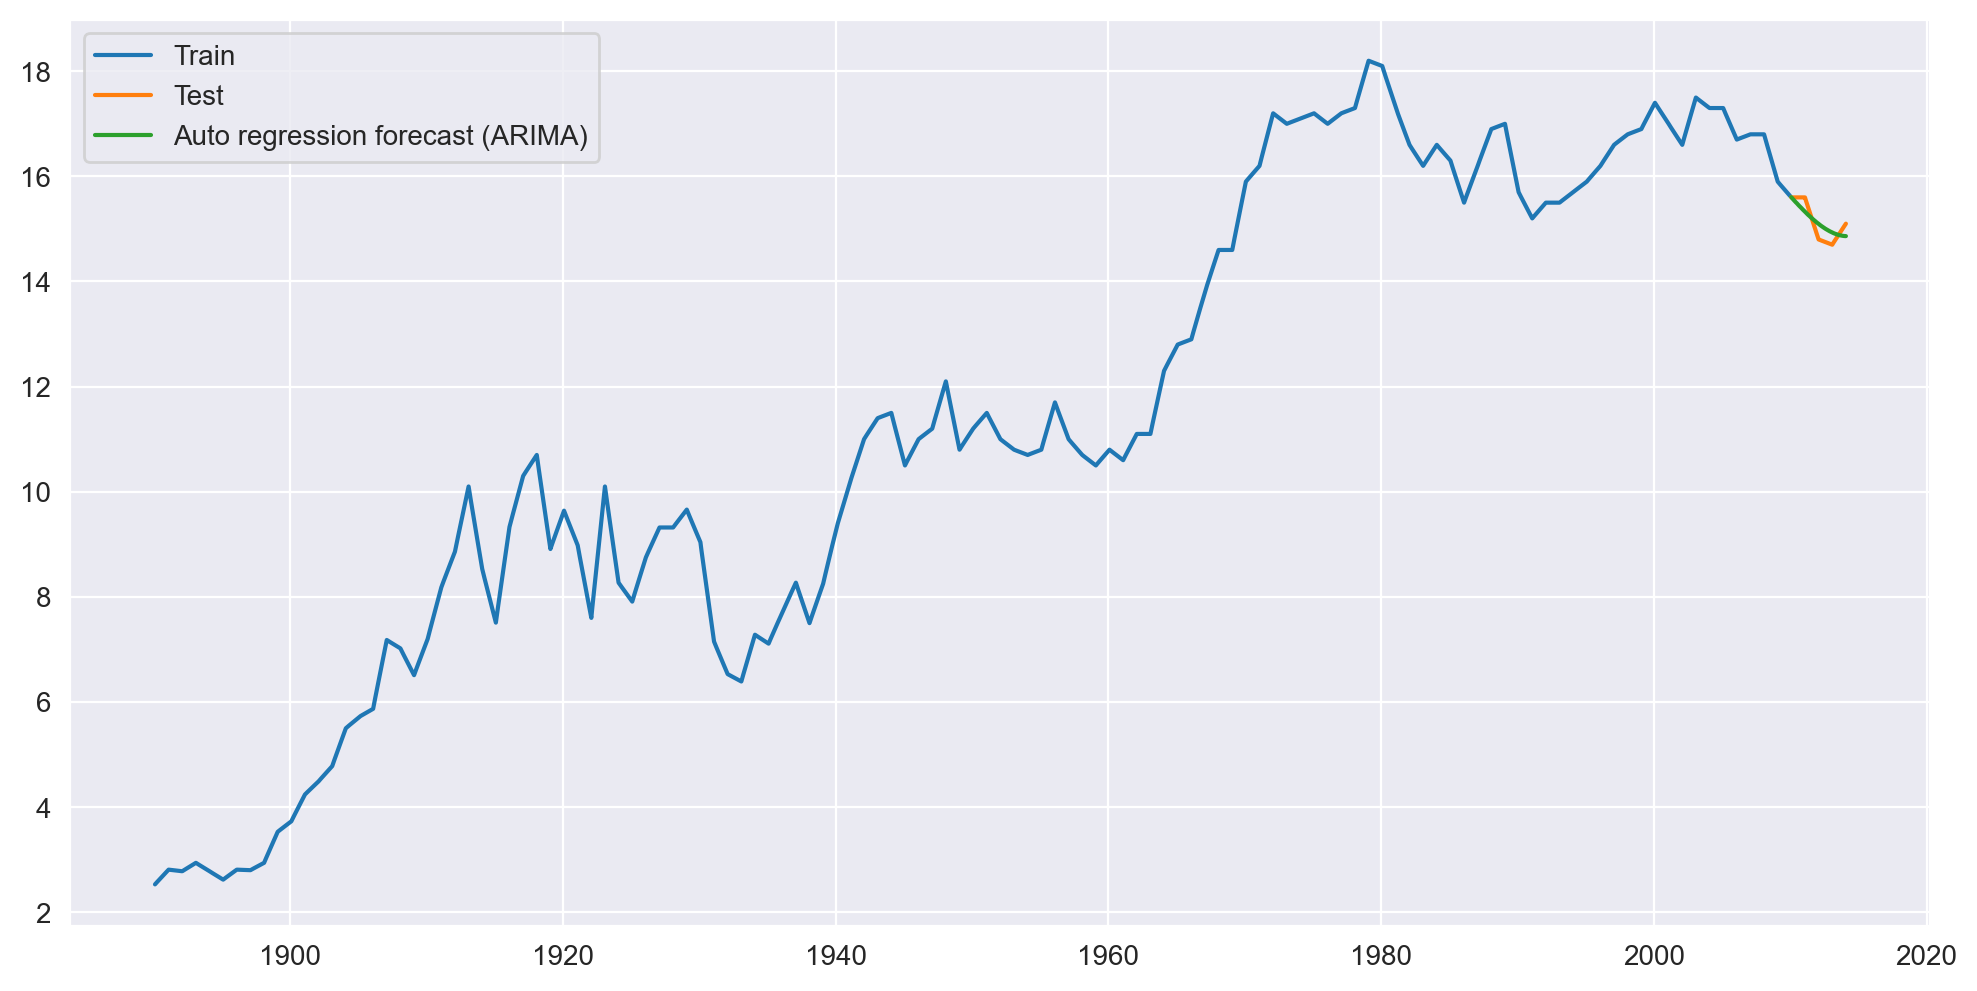

In [48]:
plt.figure(figsize=(12,6), dpi=200)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (ARIMA)')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that we have done moderately well.
2. No Seasonality captured. Only Trend has been captured

### Model Evaluation

### Training Error

In [54]:
train_arima  = arima_model_fit.fittedvalues
train_rmse_arima  = sqrt(mean_squared_error(train_arima ,train_data))
train_rmse_arima

0.07086625001618323

### Testing Error

#### RMSE (Root Mean Squared Error)

In [35]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(3)
rmse_ARIMA

0.23

In [44]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(3)
rmse_ARIMA

0.185

#### MAPE (Mean Absolute Percent Error)

In [74]:
mape_arima = round(np.mean(np.abs((test_data.CO2 - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.CO2)*100),3)
mape_arima

1.083

#### Observation
1. We can see that AR model has done reasonably good job but not better than Holt's method.
2. We souldn't compare it with Holt's method. Because Holt's method captures seasonality

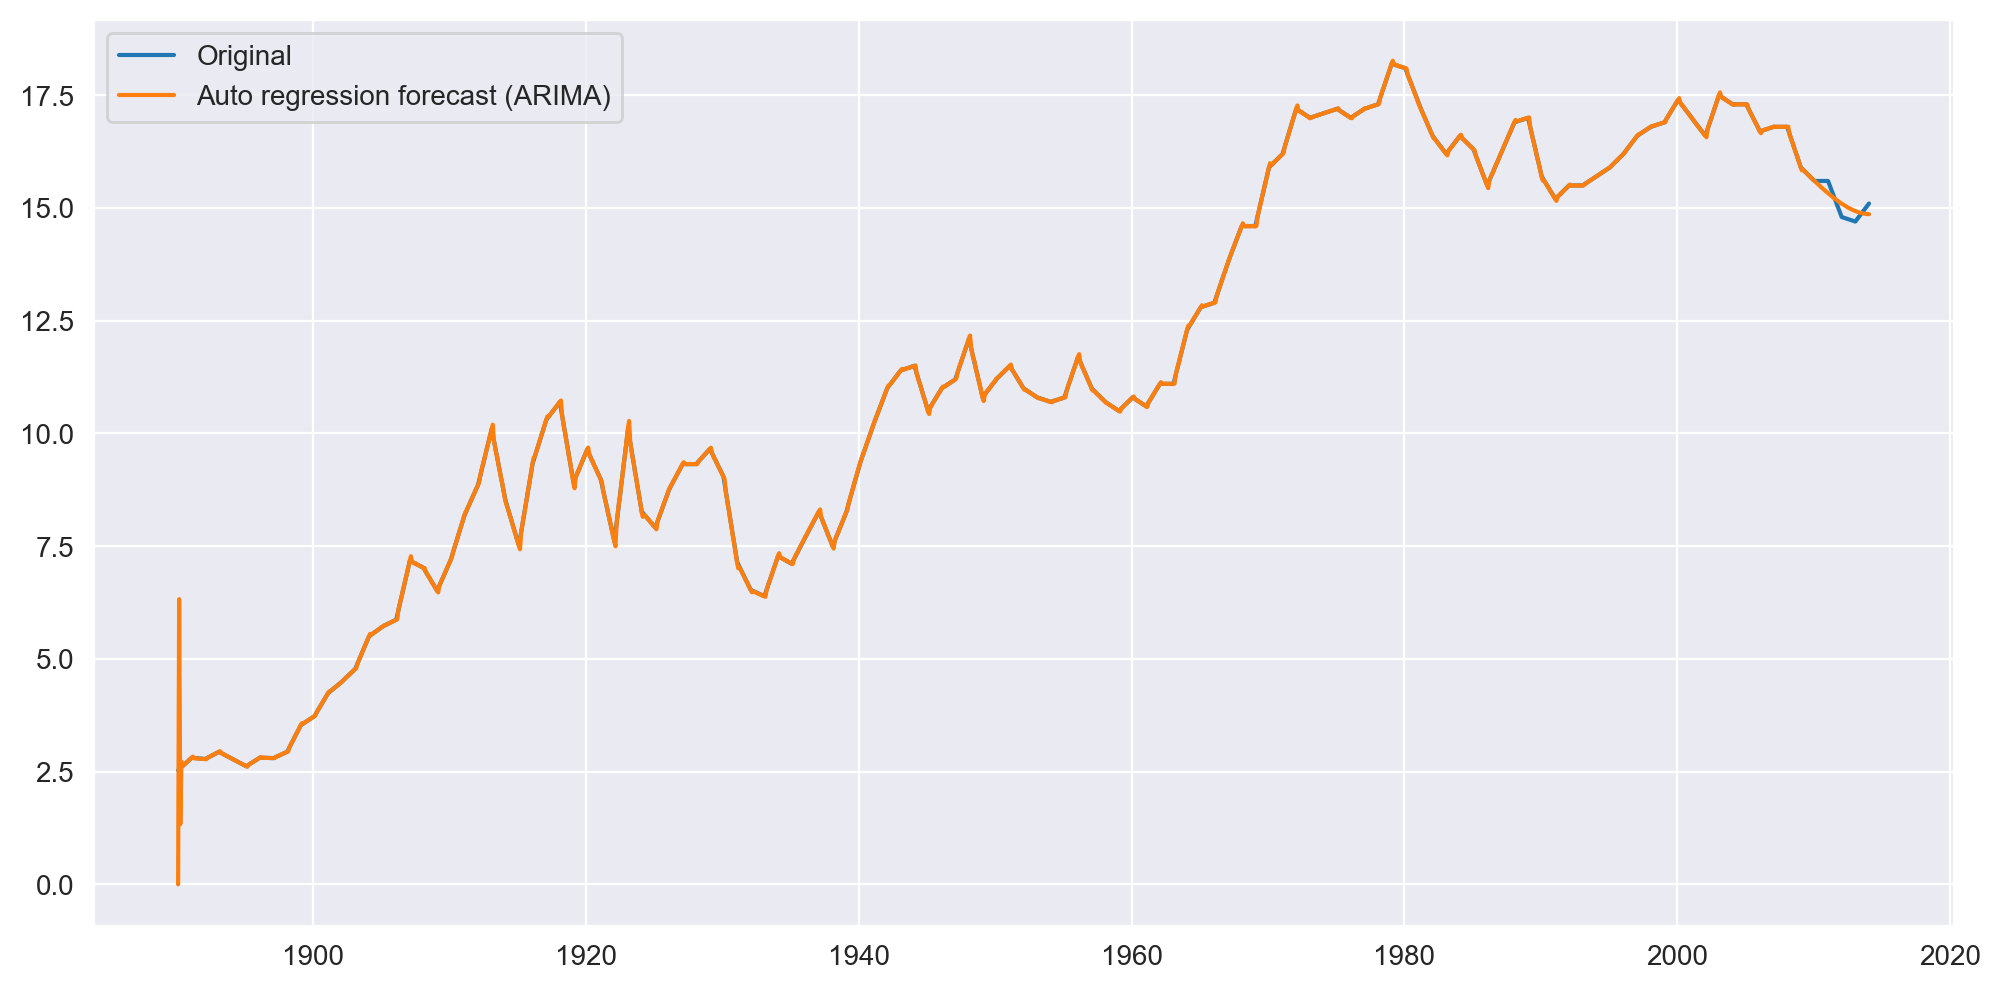

In [64]:
plt.figure(figsize=(12,6), dpi=200)
plt.plot(df['CO2'], label='Original')
plt.plot(y_hat_ar['arima_forecast'], label='Auto regression forecast (ARIMA)')
plt.legend(loc='best')
plt.show()

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [157]:
model_residual = model_fit.resid
model_residual.mean()

5.883435172804099e-06

#### Residuals must be stationary

In [158]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [159]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

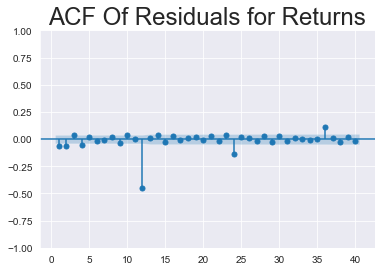

In [160]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

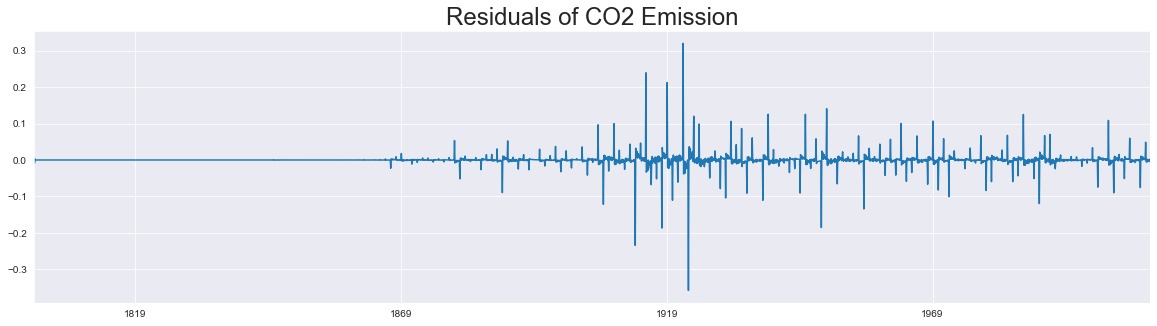

In [161]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of CO2 Emission", size=24)
plt.show()

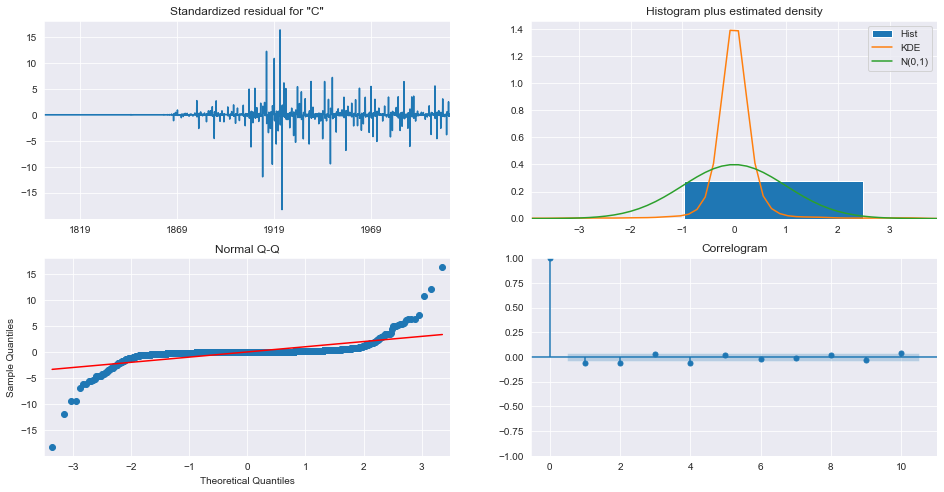

In [162]:
model_fit.plot_diagnostics(figsize=(16,8))
plt.show()

In [163]:
y_hat_ar[test_data.index.min():]

,CO2,arima_forecast
2010-01-31,15.600000,15.602658
2010-02-28,15.600000,15.579172
2010-03-31,15.600000,15.554317
2010-04-30,15.600000,15.530366
2010-05-31,15.600000,15.505562
2010-06-30,15.600000,15.482879
2010-07-31,15.600000,15.457735
2010-08-31,15.600000,15.432935
2010-09-30,15.600000,15.410339
2010-10-31,15.600000,15.386699


In [164]:
np.mean(APE.tail(20))

1.2825007767398824

### Calculating Absolute Percent Error and Error<a class="anchor" id="7.3"></a>

In [37]:
# Computing the absolute percent error
APE=100*(abs(y_hat_ar['CO2']-y_hat_ar['arima_forecast'])/y_hat_ar['CO2'])
Error = (abs(y_hat_ar['CO2']-y_hat_ar['arima_forecast']))
print('The Accuracy for Test Data -- ARIMA model = {}%'.format(np.round(100-np.mean(APE.tail(21))),2))
print('The Mean Error for Test Data -- ARIMA model = ', np.mean((Error.tail(21))))

# adding absolute percent error to table
y_hat_ar['Error']=Error
y_hat_ar['Absolute Percent Error %']=APE

y_hat_ar.tail(20)

The Accuracy for Test Data -- ARIMA model = 98.0%
The Mean Error for Test Data -- ARIMA model =  0.27012479053652816


,CO2,arima_forecast,Error,Absolute Percent Error %
2012-06-30,14.758333,15.055377,0.297044,2.012718
2012-07-31,14.750000,15.050487,0.300487,2.037203
2012-08-31,14.741667,15.047324,0.305657,2.073424
2012-09-30,14.733333,15.045722,0.312388,2.120283
2012-10-31,14.725000,15.045379,0.320379,2.175751
2012-11-30,14.716667,15.046995,0.330328,2.244587
2012-12-31,14.708333,15.050873,0.342539,2.328879
2013-01-31,14.700000,15.055936,0.355936,2.421330
2013-02-28,14.733333,15.063002,0.329669,2.237571
2013-03-31,14.766667,15.072324,0.305657,2.069912


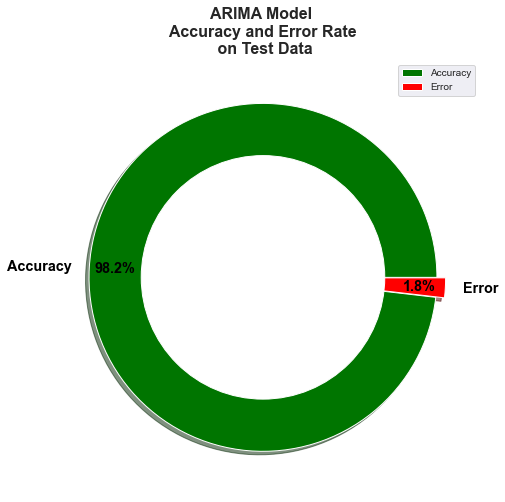

In [62]:
plt.figure(figsize=(12,8)) 
# Setting size in Chart based on 
# given values
Error_Rate = np.mean(APE.tail(21))
Accuracy = 100-np.mean(APE.tail(21))
sizes = [Accuracy, Error_Rate]
  
# Setting labels for items in Chart
labels = ['Accuracy', 'Error']
  
# colors
colors = ['#007500', '#FF0000']
  
# explosion
explode = (0.0, 0.05)
  
# Pie Chart
plt.pie(sizes, colors=colors, labels=labels,
        autopct='%1.1f%%', shadow=True,
        pctdistance=0.85, 
        explode=explode,
        startangle=0,
        textprops = {'size':'x-large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('ARIMA Model \n Accuracy and Error Rate \n on Test Data', fontsize = 16, fontweight = 'bold')
  
# Add Legends
plt.legend(labels, loc="upper right")
  
# Displaying Chart
plt.show()

[Table of Contents](#0.1)

### 7.4 Visualizing the Relationship between the Actual and Predicted ValuesModel Validation<a class="anchor" id="7.4"></a>

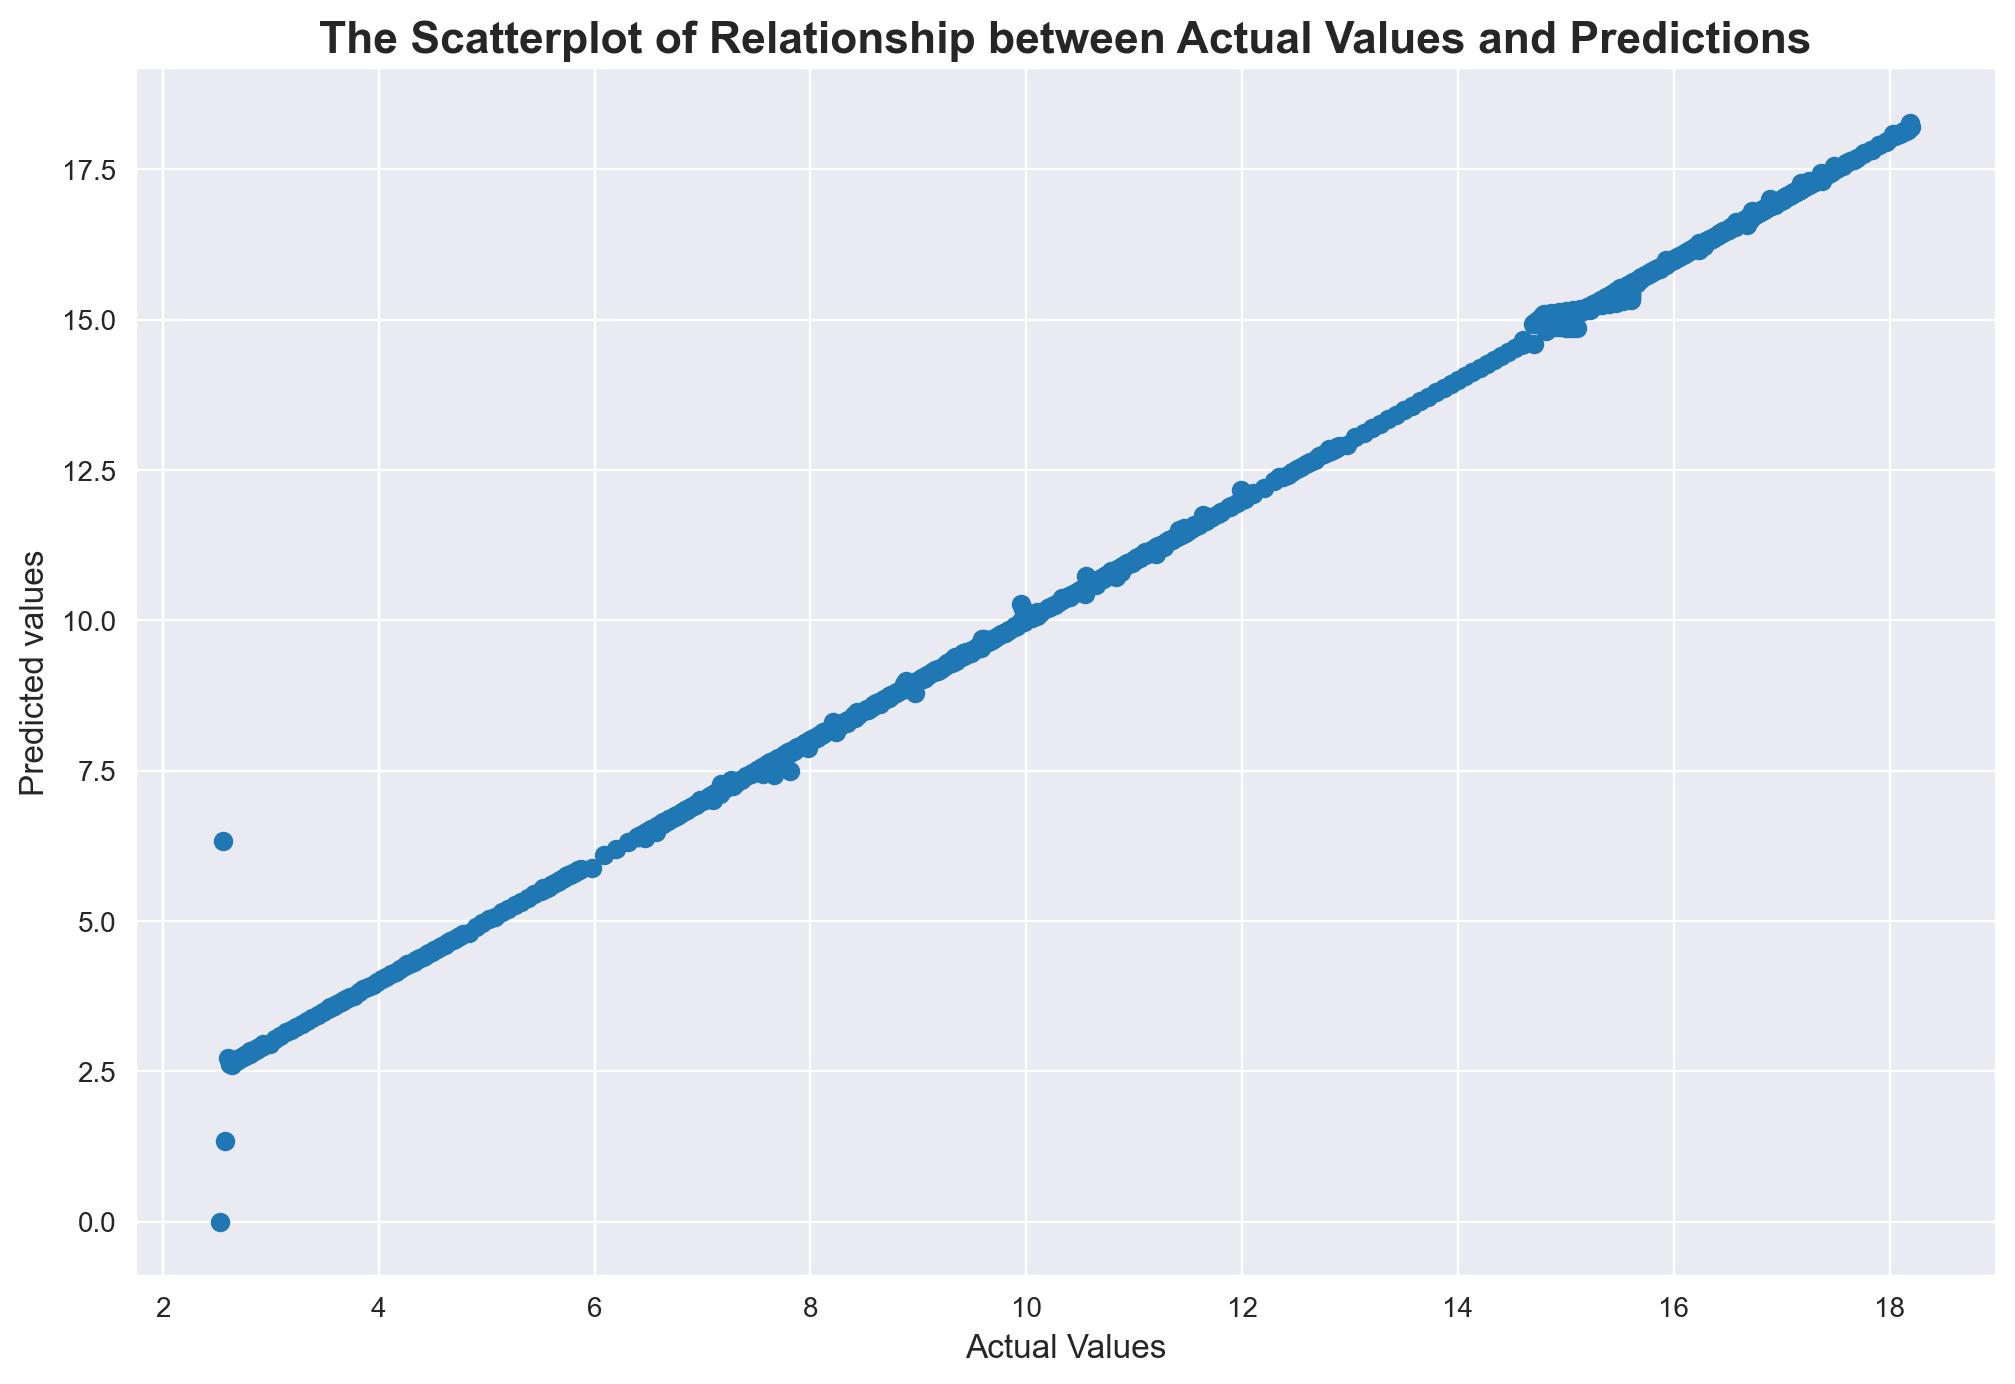

In [46]:
plt.figure(figsize=(12,8), dpi=200)
plt.xlabel("Actual Values", fontsize =12)
plt.ylabel("Predicted values", fontsize =12)
plt.title("The Scatterplot of Relationship between Actual Values and Predictions", fontsize =16, fontweight = 'bold')
plt.scatter(y_hat_ar['CO2'], y_hat_ar['arima_forecast'])
plt.show()

In [58]:
%matplotlib inline

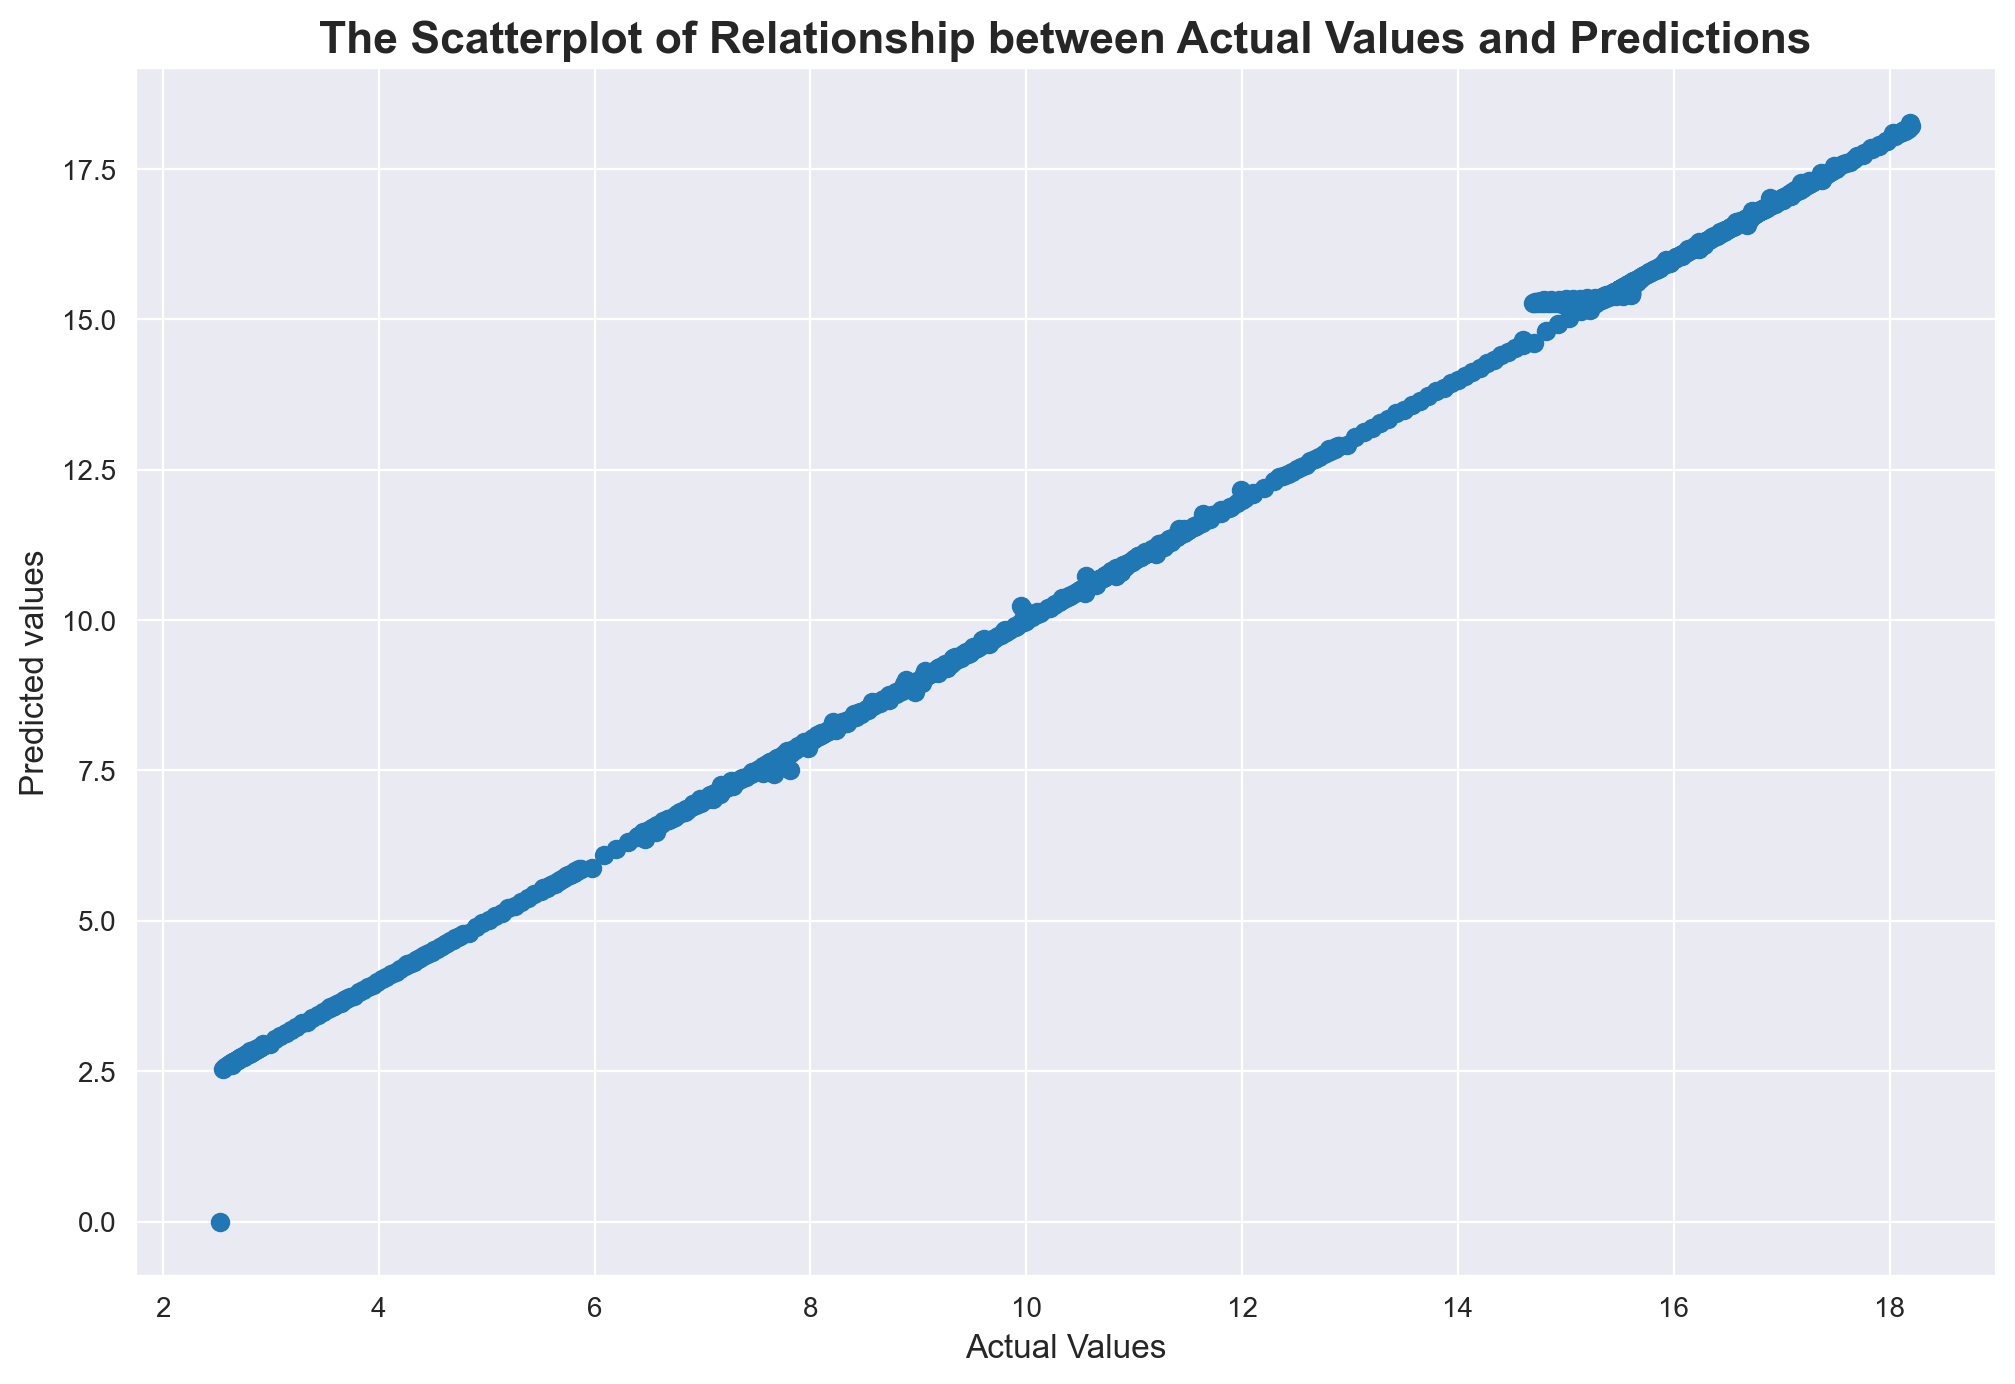

In [59]:
plt.figure(figsize=(12,8), dpi=200)
plt.xlabel("Actual Values", fontsize =12)
plt.ylabel("Predicted values", fontsize =12)
plt.title("The Scatterplot of Relationship between Actual Values and Predictions", fontsize =16, fontweight = 'bold')
plt.scatter(y_hat_ar['CO2'], y_hat_ar['arima_forecast'])
plt.show()

In [48]:
y_hat_ar.to_csv('C:/Users\Moin Dalvi\Documents\Data Science Material\Projects\Air Quality Forecasting/prediction.csv')

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)
ARIMA with Seasonal component added.

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.

In [66]:
sarima_model = SARIMAX(train_data, order=(5, 1, 6), seasonal_order=(5, 1, 6,12))
sarima_model_fit= sarima_model.fit()

#### Inverse Transformation of the Differencing Box-Cox Transformation
Note that ARIMAM automatically takes care of the reversing of `Differencing` (takes care the `Integration` part automatically). So, we don't need to perform the cumsum here. We only have to do the reverse of the log boc cox transformation.

In ARIMA, we had to perform the cumsum manually.

In [67]:
y_hat_sarima = df.copy()
y_hat_sarima['sarima_forecast'] = sarima_model_fit.predict(df.index.min(), df.index.max())

In [68]:
y_hat_sarima

,CO2,sarima_forecast
1890-01-31,2.530000,0.000000
1890-02-28,2.553333,2.530000
1890-03-31,2.576667,2.553333
1890-04-30,2.600000,2.576667
1890-05-31,2.623333,2.600000
...,...,...
2013-09-30,14.966667,15.161593
2013-10-31,15.000000,15.133861
2013-11-30,15.033333,15.106353
2013-12-31,15.066667,15.079032


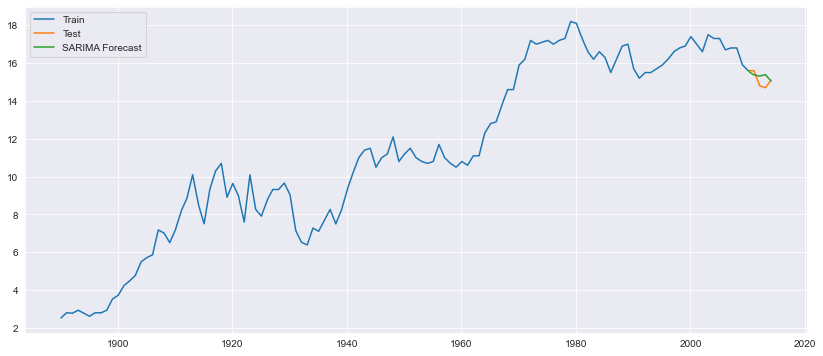

In [69]:
plt.figure(figsize=(14,6))
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

##### We can see that we are able to capture the trend and seasonality both.

### Model Evaluation

### Training Error

In [70]:
train_sarima  = arima_model_fit.fittedvalues
train_rmse_sarima  = sqrt(mean_squared_error(train_sarima ,train_data))
train_rmse_sarima

0.12647123090575033

### Testing Error

#### RMSE (Root Mean Squared Error)

In [71]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

0.38

#### MAPE (Mean Absolute Percent Error)

In [72]:
mape_sarima = round(np.mean(np.abs((test_data.CO2 - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.CO2)*100),2)
mape_sarima

2.08

#### Observation:
1. SARIMA method has done reasonably well as it captures seasonality.
2. The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality. |

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [121]:
model_residual = model_fit.resid
model_residual.mean()

-5.945569820026142e-05

#### Residuals must be stationary

In [122]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

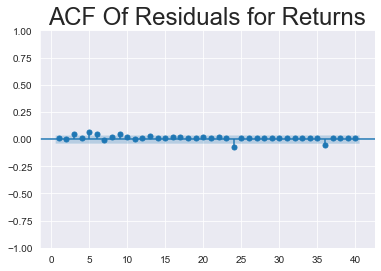

In [123]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

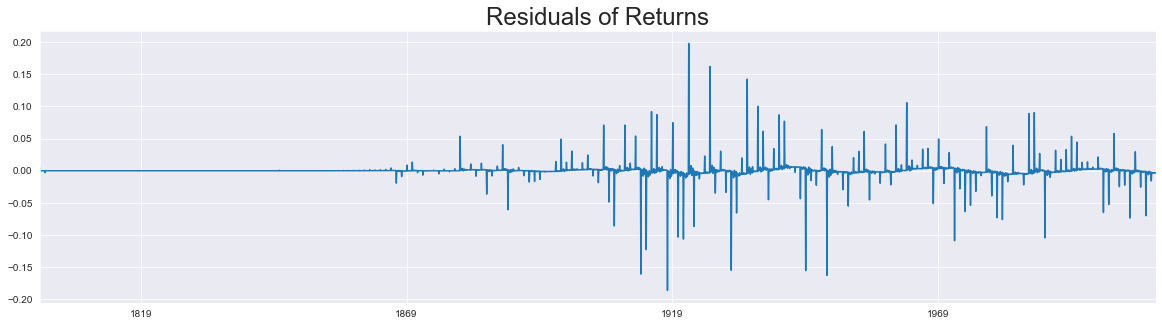

In [124]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### Creating model with differente Transformation Technique

In [75]:
#Compareing the results 

Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

,Models,MAPE(%),RMSE_Values
0,ARIMA,1.083000,0.185000
1,Triple_Exp_ad_mul,1.216806,0.242542
2,Double_Exponential,1.230683,0.248139
3,Triple_Exp_additive,1.237298,0.250615
4,Triple_Exp_multiplicative,1.288076,0.267070
5,Triple_Exp_mul_ad,1.316405,0.275498
6,SARIMA,2.080000,0.380000
7,Simple_Exponential,3.413068,0.616597


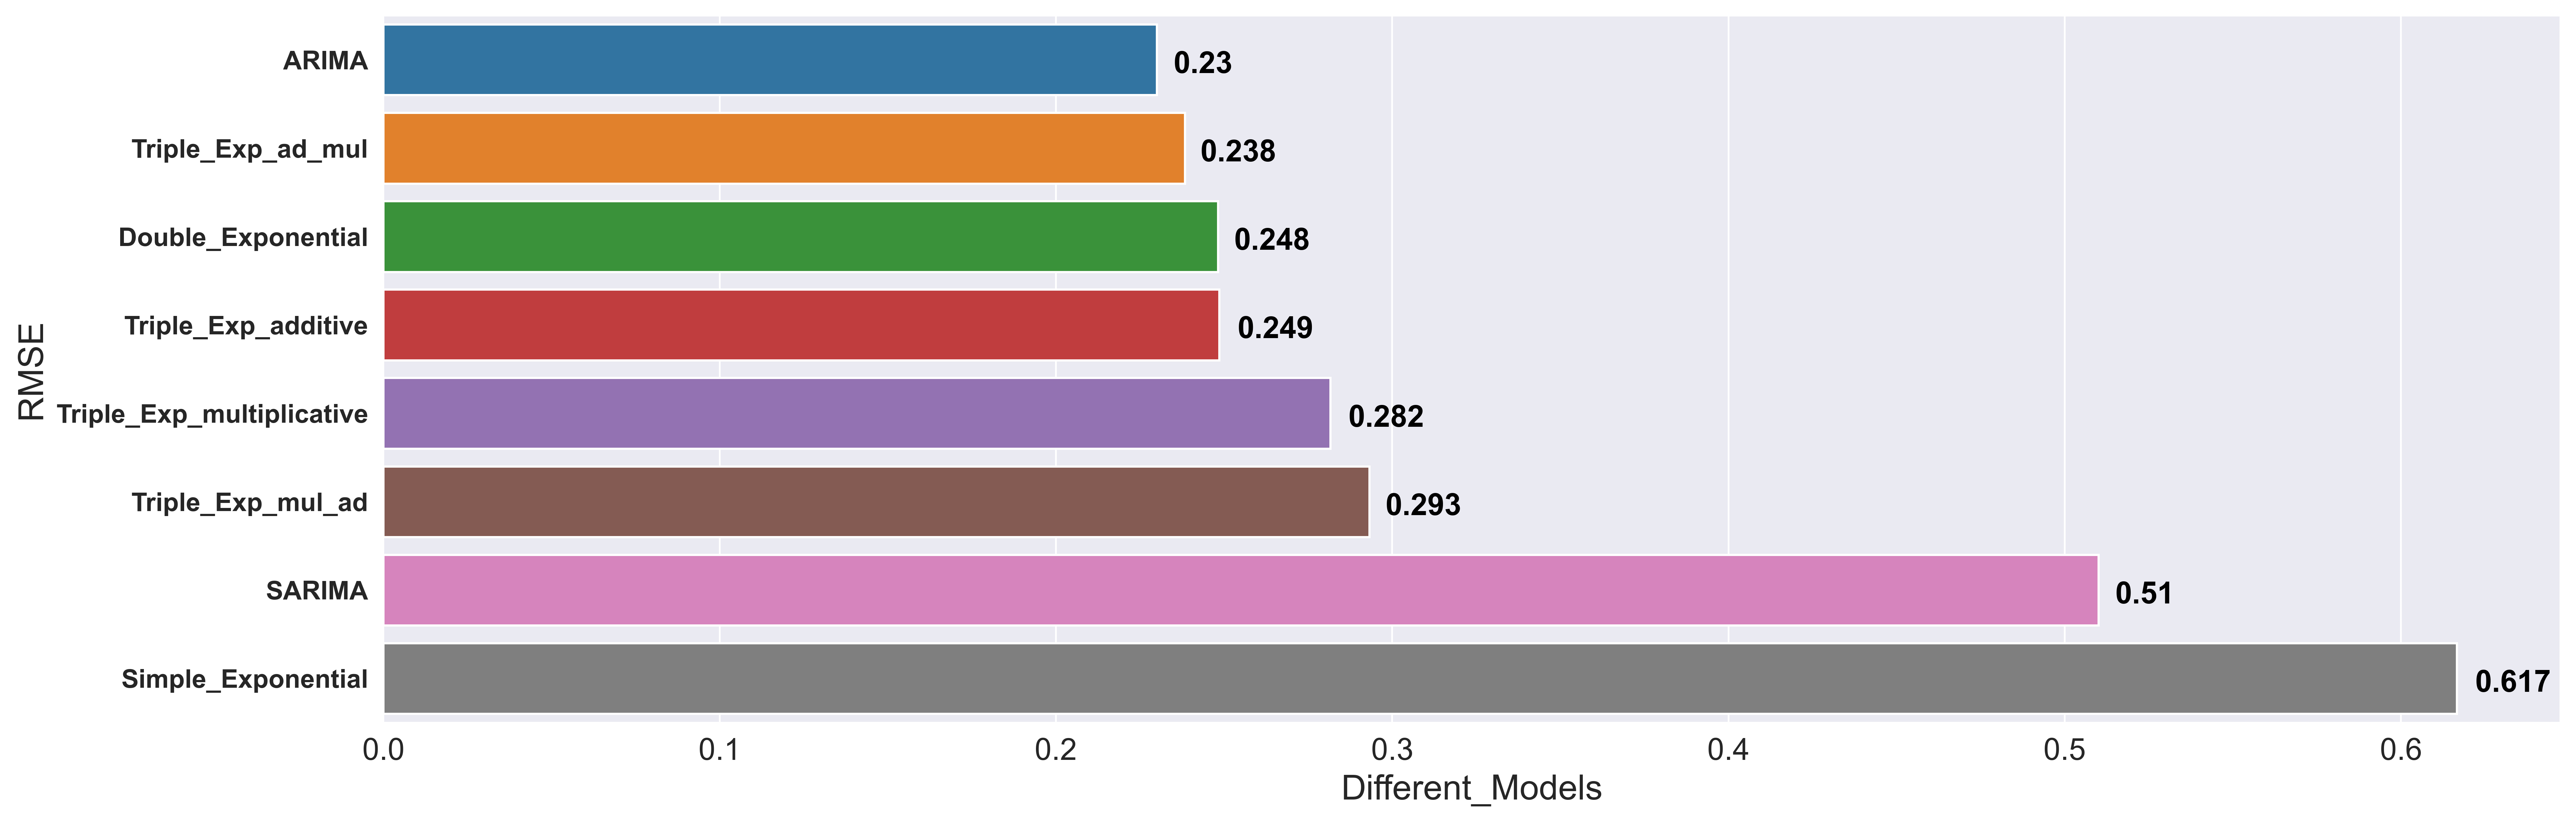

In [192]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=200)
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,3)):
    axe.text(v + 0.005, i + .15, str(v),
            color = 'black', fontweight = 'bold', fontsize= 14)

plt.show()

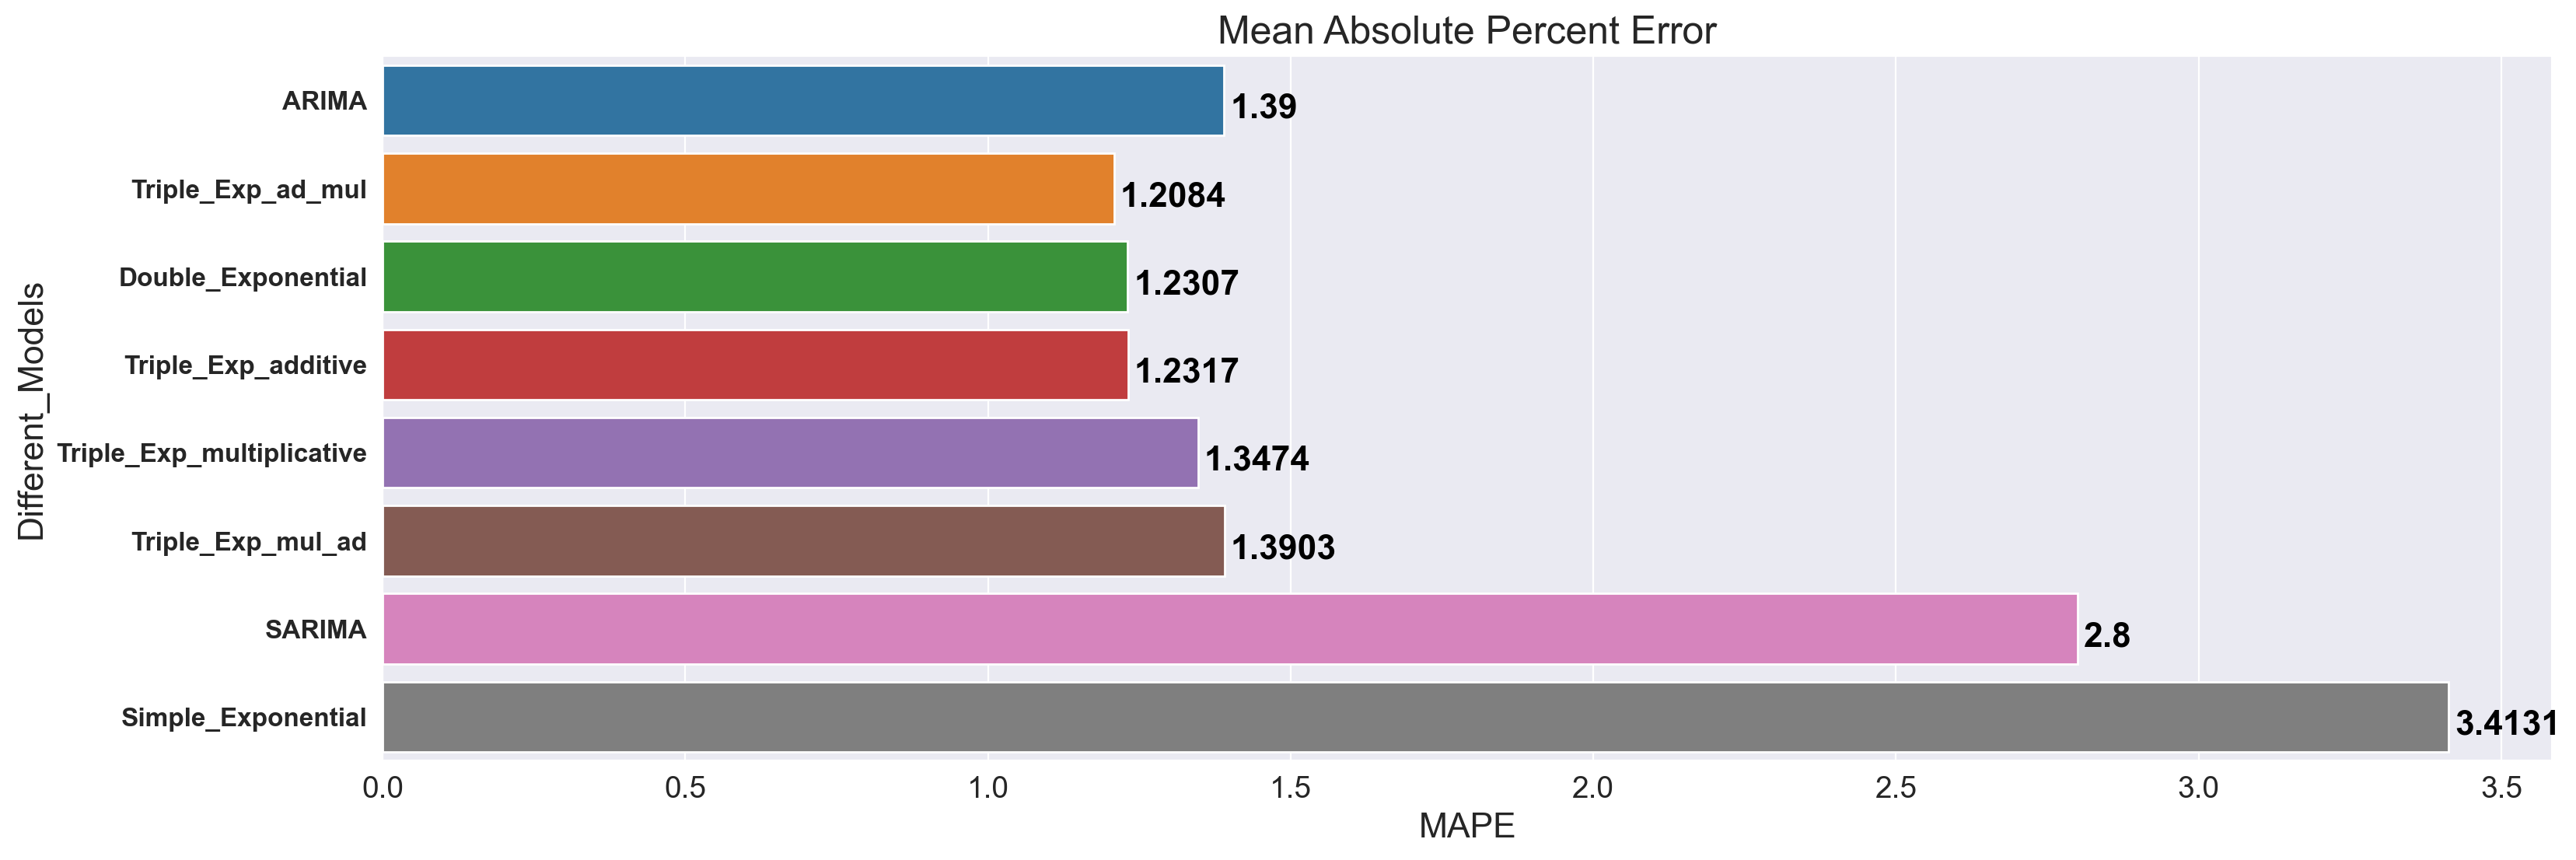

In [211]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=200)
sns.barplot(x='MAPE(%)', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('MAPE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.title("Mean Absolute Percent Error", fontsize = 18)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation['MAPE(%)'].values,4)):
    axe.text(v + 0.01, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

#### Observation:
+ **The Sarima Model did not performed very well as compared to other Models but Simple Exponential Smoothing better** 
+ **Note:Sarima with Hyperparameter tuning may get better results**
+ **Even in models such as ARIMA with hyperparameter tuning gave the best restult in this case**

#### Conclusion:
## <p style="color:black;font-size:18;">ARIMA:</p><p style="color:black;font-size:14px;">The best model we have got so far with the lowest RMSE and lowest MAPE.</p>    

### Forecasting Future Values Using ARIMA Model

#### Forecasting 5 years of data using the complete Data set

In [8]:
%matplotlib inline

In [193]:
interpolated_month.shape

(2569, 1)

In [63]:
2569+12

2581

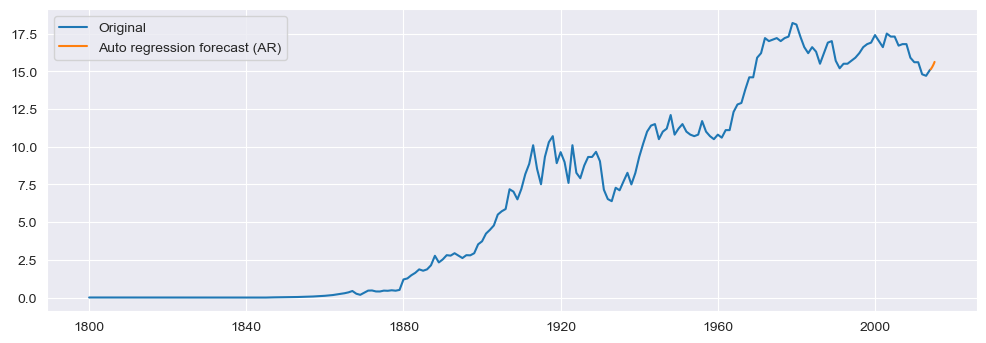

In [64]:
final_model = ARIMA(interpolated_month, order=(6, 4, 7))
final_model_fit = final_model.fit()
forecast = pd.DataFrame()
forecast['arima_forecast'] = final_model_fit.predict(start = 2569, end = 2581)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['CO2'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

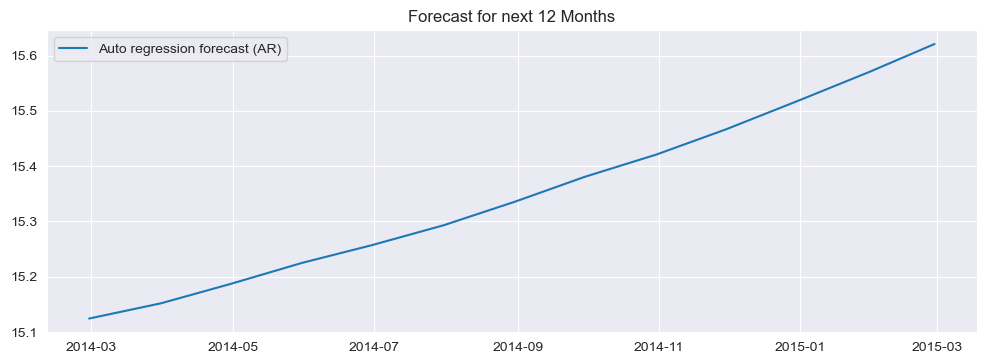

In [65]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 12 Months')
plt.legend(loc='best')
plt.show()

In [66]:
forecast

,arima_forecast
2014-02-28,15.124414
2014-03-31,15.151952
2014-04-30,15.186944
2014-05-31,15.225139
2014-06-30,15.257040
2014-07-31,15.293033
2014-08-31,15.335953
2014-09-30,15.380683
2014-10-31,15.421108
2014-11-30,15.466612


In [67]:
2569+24

2593

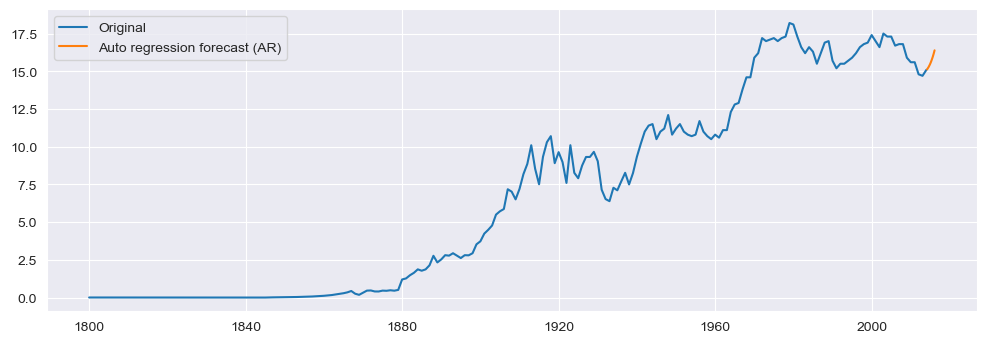

In [68]:
final_model = ARIMA(interpolated_month, order=(6, 4, 7))
final_model_fit = final_model.fit()
forecast = pd.DataFrame()
forecast['arima_forecast'] = final_model_fit.forecast(24)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['CO2'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

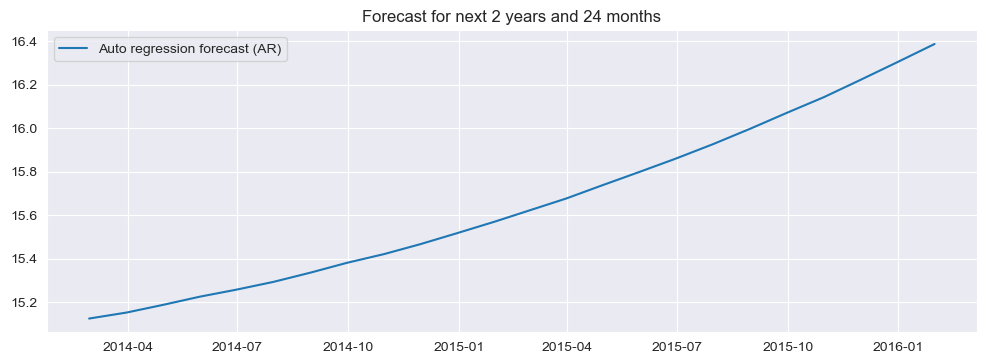

In [69]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 2 years and 24 months')
plt.legend(loc='best')
plt.show()

In [70]:
forecast

,arima_forecast
2014-02-28,15.124414
2014-03-31,15.151952
2014-04-30,15.186944
2014-05-31,15.225139
2014-06-30,15.257040
2014-07-31,15.293033
2014-08-31,15.335953
2014-09-30,15.380683
2014-10-31,15.421108
2014-11-30,15.466612


In [71]:
# Saving the pickle file
import pickle
pickle.dump(final_model_fit, open('CO2_Forecast_arima_monthly.pkl','wb'))

In [8]:
# Saving the pickle file
import pickle
pickle.dump(arima_model_fit, open('monthly_train_arima.pkl','wb'))

### Data Pre-processing for Model Driven Techniques

#### Creating Dummy Variables of the Categorical Feature Month of Date Time feature 

In [15]:
co_two_emission = pd.read_csv('CO2_dataset_FE.csv')
co_two_emission.drop('Unnamed: 0', axis=1 , inplace =True)
co_two_emission

,Year,CO2,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_CO2
0,1800-01-31,0.005680,1,1,Jan,1800,1,0,0,0,0,0,0,0,0,0,0,0,-5.170804
1,1800-02-28,0.005675,2,4,Feb,1800,0,1,0,0,0,0,0,0,0,0,0,0,-5.171750
2,1800-03-31,0.005669,3,9,Mar,1800,0,0,1,0,0,0,0,0,0,0,0,0,-5.172798
3,1800-04-30,0.005663,4,16,Apr,1800,0,0,0,1,0,0,0,0,0,0,0,0,-5.173814
4,1800-05-31,0.005657,5,25,May,1800,0,0,0,0,1,0,0,0,0,0,0,0,-5.174864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,2013-09-30,14.965205,2565,6579225,Sep,2013,0,0,0,0,0,0,0,0,1,0,0,0,2.705728
2565,2013-10-31,14.999178,2566,6584356,Oct,2013,0,0,0,0,0,0,0,0,0,1,0,0,2.707995
2566,2013-11-30,15.032055,2567,6589489,Nov,2013,0,0,0,0,0,0,0,0,0,0,1,0,2.710185
2567,2013-12-31,15.066027,2568,6594624,Dec,2013,0,0,0,0,0,0,0,0,0,0,0,1,2.712442


#### Splitting data into Train and Test 

In [14]:
size

-49

In [16]:
train_data = co_two_emission.iloc[:size]
test_data = co_two_emission.iloc[size:]

In [17]:
train_data

,Year,CO2,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_CO2
0,1800-01-31,0.005680,1,1,Jan,1800,1,0,0,0,0,0,0,0,0,0,0,0,-5.170804
1,1800-02-28,0.005675,2,4,Feb,1800,0,1,0,0,0,0,0,0,0,0,0,0,-5.171750
2,1800-03-31,0.005669,3,9,Mar,1800,0,0,1,0,0,0,0,0,0,0,0,0,-5.172798
3,1800-04-30,0.005663,4,16,Apr,1800,0,0,0,1,0,0,0,0,0,0,0,0,-5.173814
4,1800-05-31,0.005657,5,25,May,1800,0,0,0,0,1,0,0,0,0,0,0,0,-5.174864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2009-08-31,15.725753,2516,6330256,Aug,2009,0,0,0,0,0,0,0,1,0,0,0,0,2.755300
2516,2009-09-30,15.701096,2517,6335289,Sep,2009,0,0,0,0,0,0,0,0,1,0,0,0,2.753731
2517,2009-10-31,15.675616,2518,6340324,Oct,2009,0,0,0,0,0,0,0,0,0,1,0,0,2.752106
2518,2009-11-30,15.650959,2519,6345361,Nov,2009,0,0,0,0,0,0,0,0,0,0,1,0,2.750532


In [18]:
test_data

,Year,CO2,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_CO2
2520,2010-01-31,15.600000,2521,6355441,Jan,2010,1,0,0,0,0,0,0,0,0,0,0,0,2.747271
2521,2010-02-28,15.600000,2522,6360484,Feb,2010,0,1,0,0,0,0,0,0,0,0,0,0,2.747271
2522,2010-03-31,15.600000,2523,6365529,Mar,2010,0,0,1,0,0,0,0,0,0,0,0,0,2.747271
2523,2010-04-30,15.600000,2524,6370576,Apr,2010,0,0,0,1,0,0,0,0,0,0,0,0,2.747271
2524,2010-05-31,15.600000,2525,6375625,May,2010,0,0,0,0,1,0,0,0,0,0,0,0,2.747271
2525,2010-06-30,15.600000,2526,6380676,Jun,2010,0,0,0,0,0,1,0,0,0,0,0,0,2.747271
2526,2010-07-31,15.600000,2527,6385729,Jul,2010,0,0,0,0,0,0,1,0,0,0,0,0,2.747271
2527,2010-08-31,15.600000,2528,6390784,Aug,2010,0,0,0,0,0,0,0,1,0,0,0,0,2.747271
2528,2010-09-30,15.600000,2529,6395841,Sep,2010,0,0,0,0,0,0,0,0,1,0,0,0,2.747271
2529,2010-10-31,15.600000,2530,6400900,Oct,2010,0,0,0,0,0,0,0,0,0,1,0,0,2.747271


### Building Ordinary Square Model (Linear Model)

In [19]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('CO2~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(pred_linear))**2))
rmse_linear

2.3469371365460074

In [22]:
mape_linear= MAPE(pred_linear,test_data.CO2)
mape_linear 

15.309208303814117

In [23]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CO2   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 2.418e+04
Date:                Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:44:39   Log-Likelihood:                -5299.8
No. Observations:                2520   AIC:                         1.060e+04
Df Residuals:                    2518   BIC:                         1.062e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0675      0.079    -51.472      0.000      -4.222      -3.913
t              0.0084   5.43e-05    155.500      0.000       0.008       0.009
==============================================================================
Omnibus:                      361.729   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.441
Skew:                           0.185   Prob(JB):                     1.55e-22
Kurtosis:                       2.095   Cond. No.                     2.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#Exponential

Exp = smf.ols('log_CO2~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

156.35984471217714

In [25]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_CO2   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                 1.246e+04
Date:                Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:44:41   Log-Likelihood:                -4352.6
No. Observations:                2520   AIC:                             8709.
Df Residuals:                    2518   BIC:                             8721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4499      0.054   -100.430      0.000      -5.556      -5.343
t              0.0042   3.73e-05    111.604      0.000       0.004       0.004
==============================================================================
Omnibus:                      375.297   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.534
Skew:                          -0.222   Prob(JB):                     4.46e-24
Kurtosis:                       2.091   Cond. No.                     2.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
#Quadratic 

Quad = smf.ols('CO2~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(pred_Quad))**2))
rmse_Quad

5.324067931744713

In [27]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CO2   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 2.123e+04
Date:                Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:44:43   Log-Likelihood:                -4641.9
No. Observations:                2520   AIC:                             9290.
Df Residuals:                    2517   BIC:                             9307.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2375      0.091    -13.545      0.000      -1.417      -1.058
t              0.0017      0.000     10.219      0.000       0.001       0.002
t_squared   2.671e-06   6.43e-08     41.542      0.000    2.54e-06     2.8e-06
==============================================================================
Omnibus:                       73.688   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.137
Skew:                           0.398   Prob(JB):                     4.83e-17
Kurtosis:                       2.712   Cond. No.                     8.53e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.53e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
#Additive seasonality 

add_sea = smf.ols('CO2~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(pred_add_sea))**2))
rmse_add_sea

8.550486935037249

In [29]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CO2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.002511
Date:                Tue, 16 Aug 2022   Prob (F-statistic):               1.00
Time:                        19:44:47   Log-Likelihood:                -8274.8
No. Observations:                2520   AIC:                         1.657e+04
Df Residuals:                    2508   BIC:                         1.664e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0695      0.119     51.021      0.000       5.836       6.303
Jan            0.4721      0.428      1.104      0.270      -0.366       1.310
Feb            0.4777      0.428      1.117      0.264      -0.361       1.316
Mar            0.4840      0.428      1.132      0.258      -0.354       1.322
Apr            0.4901      0.428      1.146      0.252      -0.348       1.329
May            0.4964      0.428      1.161      0.246      -0.342       1.335
Jun            0.5025      0.428      1.175      0.240      -0.336       1.341
Jul            0.5089      0.428      1.190      0.234      -0.330       1.347
Aug            0.5152      0.428      1.205      0.228      -0.323       1.354
Sep            0.5213      0.428      1.219      0.223      -0.317       1.360
Oct            0.5276      0.428      1.234      0.217      -0.311       1.366
Nov            0.5337      0.428      1.248      0.212      -0.305       1.372
Dec            0.5400      0.428      1.263      0.207      -0.298       1.378
==============================================================================
Omnibus:                   100298.130   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.708
Skew:                           0.408   Prob(JB):                     1.48e-57
Kurtosis:                       1.649   Cond. No.                     2.23e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.49e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('CO2~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

5.32428740260108

In [31]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CO2   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     3253.
Date:                Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:44:58   Log-Likelihood:                -4641.8
No. Observations:                2520   AIC:                             9312.
Df Residuals:                    2506   BIC:                             9393.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1424      0.085    -13.516      0.000      -1.308      -0.977
t              0.0017      0.000     10.197      0.000       0.001       0.002
t_squared   2.671e-06   6.44e-08     41.452      0.000    2.54e-06     2.8e-06
Jan           -0.0825      0.101     -0.814      0.416      -0.281       0.116
Feb           -0.0853      0.101     -0.841      0.400      -0.284       0.114
Mar           -0.0874      0.101     -0.862      0.389      -0.286       0.111
Apr           -0.0897      0.101     -0.885      0.376      -0.289       0.109
May           -0.0919      0.101     -0.906      0.365      -0.291       0.107
Jun           -0.0942      0.101     -0.929      0.353      -0.293       0.105
Jul           -0.0963      0.101     -0.950      0.342      -0.295       0.102
Aug           -0.0985      0.101     -0.971      0.332      -0.297       0.100
Sep           -0.1008      0.101     -0.994      0.320      -0.300       0.098
Oct           -0.1030      0.101     -1.015      0.310      -0.302       0.096
Nov           -0.1053      0.101     -1.039      0.299      -0.304       0.094
Dec           -0.1075      0.101     -1.060      0.289      -0.306       0.091
==============================================================================
Omnibus:                       73.770   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.203
Skew:                           0.398   Prob(JB):                     4.68e-17
Kurtosis:                       2.712   Cond. No.                     2.27e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.95e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [32]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_CO2~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

14.307322220661993

In [33]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_CO2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.002521
Date:                Tue, 16 Aug 2022   Prob (F-statistic):               1.00
Time:                        19:45:01   Log-Likelihood:                -6599.0
No. Observations:                2520   AIC:                         1.322e+04
Df Residuals:                    2508   BIC:                         1.329e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1888      0.061     -3.086      0.002      -0.309      -0.069
Jan           -0.0355      0.220     -0.161      0.872      -0.467       0.396
Feb           -0.0310      0.220     -0.141      0.888      -0.462       0.400
Mar           -0.0266      0.220     -0.121      0.904      -0.458       0.405
Apr           -0.0229      0.220     -0.104      0.917      -0.454       0.408
May           -0.0193      0.220     -0.088      0.930      -0.450       0.412
Jun           -0.0161      0.220     -0.073      0.942      -0.447       0.415
Jul           -0.0130      0.220     -0.059      0.953      -0.444       0.418
Aug           -0.0100      0.220     -0.046      0.964      -0.441       0.421
Sep           -0.0074      0.220     -0.033      0.973      -0.439       0.424
Oct           -0.0048      0.220     -0.022      0.983      -0.436       0.426
Nov           -0.0024      0.220     -0.011      0.991      -0.434       0.429
Dec        -1.295e-05      0.220  -5.89e-05      1.000      -0.431       0.431
==============================================================================
Omnibus:                     1245.117   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.824
Skew:                          -0.749   Prob(JB):                     6.02e-80
Kurtosis:                       1.891   Cond. No.                     2.23e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.49e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [34]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_CO2~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['CO2'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

156.36313214421423

In [35]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_CO2   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1033.
Date:                Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:45:05   Log-Likelihood:                -4352.6
No. Observations:                2520   AIC:                             8731.
Df Residuals:                    2507   BIC:                             8807.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.0307      0.050   -100.211      0.000      -5.129      -4.932
t              0.0042   3.74e-05    111.360      0.000       0.004       0.004
Jan           -0.4161      0.090     -4.611      0.000      -0.593      -0.239
Feb           -0.4157      0.090     -4.607      0.000      -0.593      -0.239
Mar           -0.4156      0.090     -4.604      0.000      -0.593      -0.239
Apr           -0.4159      0.090     -4.609      0.000      -0.593      -0.239
May           -0.4165      0.090     -4.615      0.000      -0.594      -0.240
Jun           -0.4175      0.090     -4.626      0.000      -0.594      -0.240
Jul           -0.4185      0.090     -4.637      0.000      -0.596      -0.242
Aug           -0.4198      0.090     -4.651      0.000      -0.597      -0.243
Sep           -0.4213      0.090     -4.667      0.000      -0.598      -0.244
Oct           -0.4228      0.090     -4.684      0.000      -0.600      -0.246
Nov           -0.4246      0.090     -4.704      0.000      -0.602      -0.248
Dec           -0.4264      0.090     -4.724      0.000      -0.603      -0.249
==============================================================================
Omnibus:                      375.368   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.535
Skew:                          -0.222   Prob(JB):                     4.46e-24
Kurtosis:                       2.091   Cond. No.                     1.21e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.64e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [76]:
#Compare the results 

data = {"Models":pd.Series(["Linear_Regression","Linear_Regression_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [77]:
#Compare the results 

data = {"Models":pd.Series(["Simple_Linear_Regression"]),'MAPE(%)':pd.Series([mape_linear]),"RMSE_Values":pd.Series([rmse_linear])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [78]:
e = table_rmse.append(table_evaluation)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [79]:
e

,Models,MAPE(%),RMSE_Values
0,ARIMA,1.083000,0.185000
1,Triple_Exp_ad_mul,1.216806,0.242542
2,Double_Exponential,1.230683,0.248139
3,Triple_Exp_additive,1.237298,0.250615
4,Triple_Exp_multiplicative,1.288076,0.267070
5,Triple_Exp_mul_ad,1.316405,0.275498
6,SARIMA,2.080000,0.380000
7,Simple_Exponential,3.413068,0.616597
8,Simple_Linear_Regression,15.309208,2.346937


### Model Performance on Resampled data from Yearly to Monthly data using Linear Interpolation

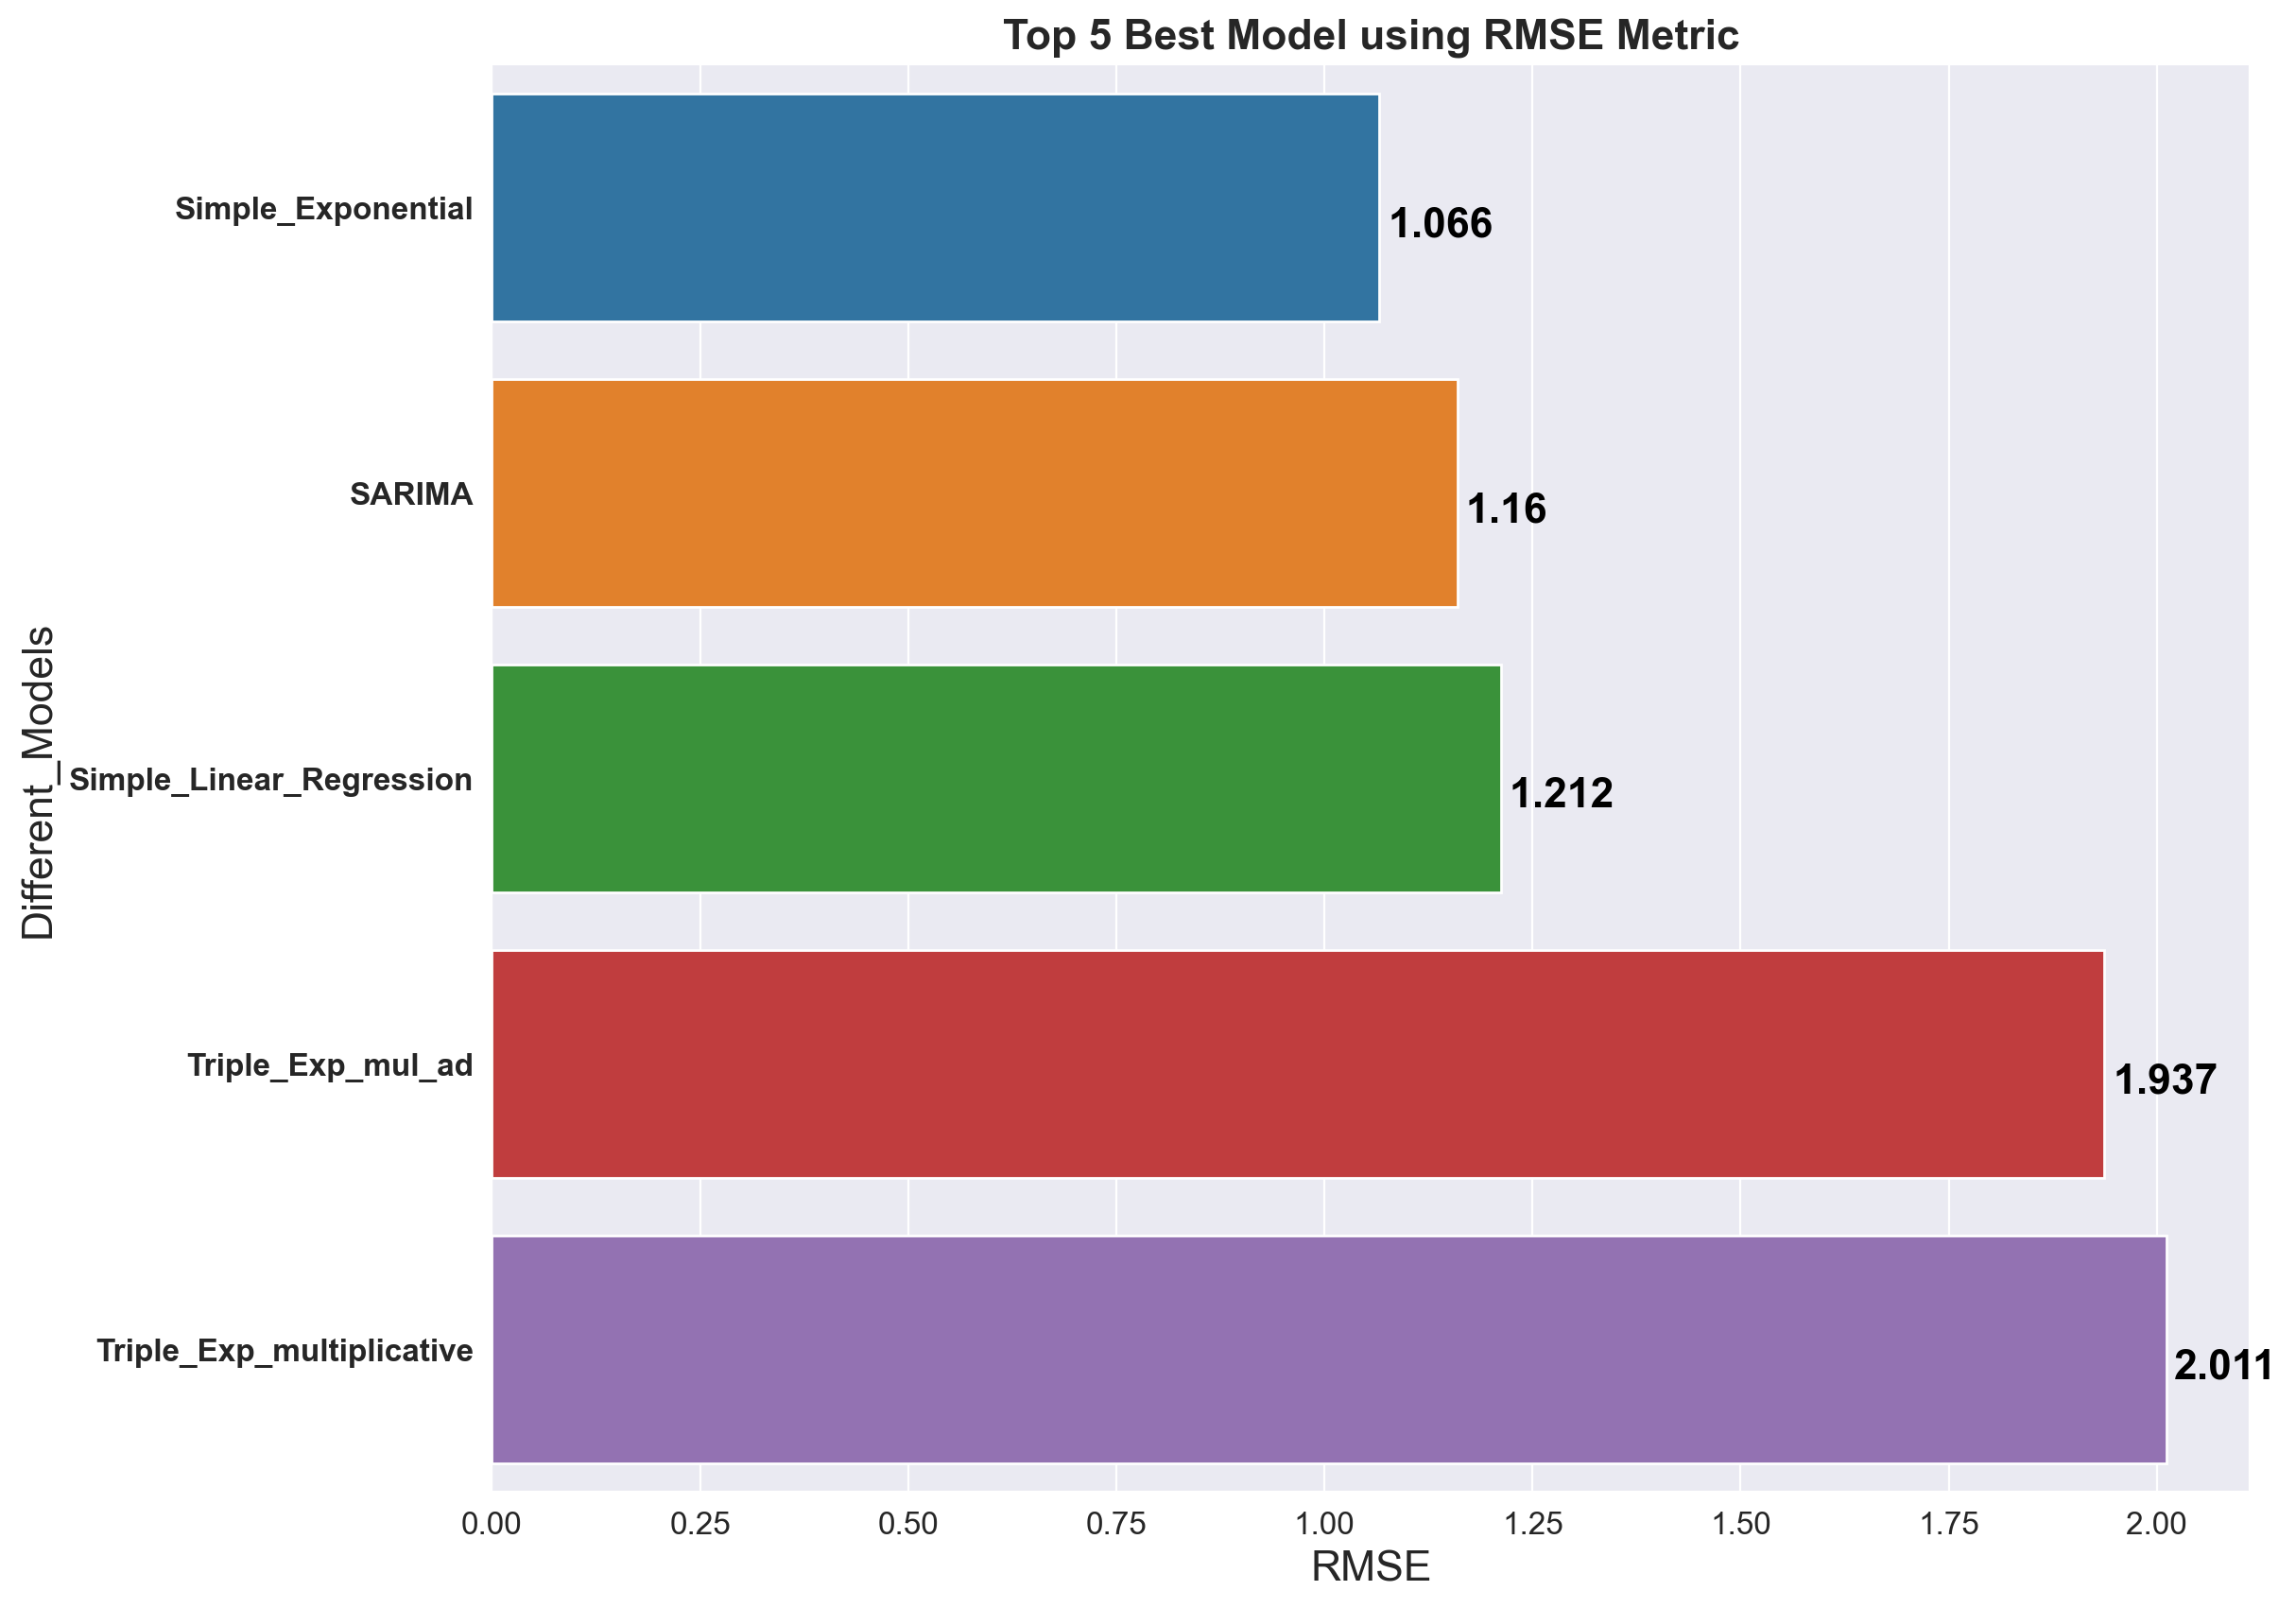

In [142]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=200)
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
plt.title('Top 5 Best Model using RMSE Metric', fontsize=16, fontweight='bold')

for i, v in enumerate(np.round(e.RMSE_Values.values,3)):
    axe.text(v + 0.01, i + .1, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

#### Conclusion:
## <p style="color:black;font-size:18;">Simple Exponential Method:</p><p style="color:black;font-size:14px;">The best model we have got so far with the lowest RMSE and lowest MAPE.</p>    

## Links for the repositories

<div style="display:fill;
            border-radius: false;
            border-style: solid;
            border-color:#000000;
            border-style: false;
            border-width: 2px;
            color:#CF673A;
            font-size:15px;
            font-family: Georgia;
            background-color:#E8DCCC;
            text-align:center;
            letter-spacing:0.1px;
            padding: 0.1em;">

**<h2>♡ Thank you for taking the time ♡**